# NOAA Atlas 14 AEP Events for HEC-RAS

## Overview

This notebook demonstrates **design storm generation** using NOAA Atlas 14 precipitation frequency data for HEC-RAS unsteady flow modeling. Atlas 14 provides statistically-derived precipitation depths for various recurrence intervals and durations, essential for:

- **Regulatory Floodplain Mapping**: FEMA requires Atlas 14 for many jurisdictions
- **Design Storm Analysis**: Infrastructure design (culverts, detention, channels)
- **Risk Assessment**: Quantifying flood hazard for different return periods
- **Climate Preparedness**: Understanding extreme precipitation probabilities

### What This Notebook Does

1. Queries NOAA Atlas 14 precipitation frequency server for project location
2. Retrieves precipitation depths for specified AEP (Annual Exceedance Probability) events
3. Converts depth-duration-frequency to hyetograph (time-varying rainfall)
4. Applies temporal distribution (SCS Type II, Type III, custom)
5. Generates HEC-HMS or HEC-RAS boundary condition files
6. Runs HEC-RAS for multiple design storms
7. Compares flood extents and depths across return periods

### LLM Forward Principle: Authoritative Data Sources

NOAA Atlas 14 is the **authoritative source** for precipitation frequency in the United States:
- **Peer-Reviewed**: Published by NOAA's National Weather Service
- **Statistically Rigorous**: Based on partial duration series analysis of observed data
- **Spatially Interpolated**: Point estimates with confidence intervals
- **Regularly Updated**: Regional volumes published 2004-2019, updates ongoing

**Professional Responsibility**: Using unofficial or outdated precipitation data may invalidate regulatory submittals.

### NOAA Atlas 14 Background

**Statistical Basis**:
- **L-Moments Regional Frequency Analysis**: Robust parameter estimation
- **Partial Duration Series**: Captures multiple events per year (vs Annual Max)
- **Generalized Extreme Value (GEV) Distribution**: Fits precipitation extremes
- **Confidence Intervals**: 90% bounds on depth estimates

**Coverage**:
- **Volume 1**: Semiarid Southwest (2004)
- **Volume 2**: Ohio River Basin and Surrounding States (2006)
- **Volume 3**: Puerto Rico and Virgin Islands (2006)
- **Volume 7**: Alaska (2012)
- **Volume 8**: Midwestern States (2013)
- **Volume 9**: Southeastern States (2013)
- **Volume 10**: Northeastern States (2015)
- **Volume 11**: Texas (2018)

**Access Methods**:
1. **PFDS Web Interface**: [https://hdsc.nws.noaa.gov/pfds/](https://hdsc.nws.noaa.gov/pfds/)
2. **NOAA Atlas 14 GIS Data**: Shapefiles and rasters
3. **API Access**: Automated queries (used by this notebook)

### Reference

For NOAA Atlas 14 methodology:
- [NOAA Atlas 14 Main Page](https://www.weather.gov/owp/hdsc_precipitation_frequency)
- [NOAA Atlas 14 Documentation](https://www.weather.gov/owp/hdsc_publications)
- [Perica et al. (2013) Atlas 14 Volume 9: Southeastern States](https://www.weather.gov/media/owp/oh/hdsc/docs/Atlas14_Volume9.pdf)

For temporal distribution methods:
- [USDA NRCS TR-55: Urban Hydrology for Small Watersheds](https://www.nrcs.usda.gov/wps/portal/nrcs/detailfull/national/water/?cid=stelprdb1042901)
- [SCS Type II, III Rainfall Distributions](https://www.nrcs.usda.gov/wps/portal/nrcs/detailfull/national/water/manage/hydrology/?cid=stelprdb1043063)

For HEC-RAS design storm modeling:
- [HEC-RAS User Manual: Precipitation Boundary Conditions](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)

### Design Storm Parameters

**Recurrence Interval vs AEP**:
- **1% AEP** = 100-year event (1/100 = 0.01 probability annually)
- **10% AEP** = 10-year event
- **50% AEP** = 2-year event

**Duration Selection**:
- **Short Duration** (1-6 hr): Convective storms, small watersheds
- **Long Duration** (24 hr): Tropical systems, large watersheds
- **Critical Duration**: Produces maximum peak flow (≈ time of concentration)

**Temporal Distribution**:
- **SCS Type I**: Pacific maritime climate (24-hr)
- **SCS Type IA**: Pacific maritime climate, high intensity (24-hr)
- **SCS Type II**: Rest of United States (24-hr)
- **SCS Type III**: Gulf Coast and adjacent areas (24-hr)
- **Custom**: Project-specific distributions from observed data

### Common Applications

**FEMA Floodplain Studies**:
- 1% AEP (100-yr) for regulatory floodplain delineation
- 0.2% AEP (500-yr) for areas of moderate flood hazard

**Stormwater Management**:
- 10% AEP (10-yr) for minor storm design
- 1% AEP (100-yr) for major storm design

**Dam Safety**:
- PMF (Probable Maximum Flood) for high-hazard dams
- 1% AEP, 0.5% AEP for intermediate hazard

### Interpretation Guidance

**Expected Results**:
- Peak discharge increases ~2-3x from 10-yr to 100-yr event
- Flood extent area increases nonlinearly (floodplain storage effects)
- Water surface elevations may not scale linearly with rainfall depth

**Quality Checks**:
- Peak flow timing should align with critical storm duration
- Verify rational method comparison (Q = CiA) for small watersheds
- Check that 100-yr flood contains 10-yr flood (nested boundaries)

### Common Pitfalls

- **Wrong Atlas 14 Volume**: Ensure data matches project location
- **Spatial Averaging**: Atlas 14 is point precipitation (not watershed-averaged)
- **Duration Mismatch**: Critical duration varies with watershed size
- **Infiltration Assumptions**: AMC (Antecedent Moisture Condition) significantly affects runoff
- **Climate Change**: Atlas 14 is stationary statistics (does not account for climate trends)


## Parameters

Configure these values to customize the notebook for your project.

In [1]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Davis"              # Example project to extract
RAS_VERSION = "6.6"                   # HEC-RAS version

# Atlas14 Location Settings
LATITUDE = 40.1934                    # Latitude for Atlas14 data
LONGITUDE = -85.3863                  # Longitude for Atlas14 data

# Storm Duration and AEP Settings
STORM_DURATION_HOURS = 24             # Storm duration in hours
AEP_VALUES = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01, 0.005, 0.002]  # Annual exceedance probabilities

# Execution Settings
PLAN = "01"                           # Base plan to modify
NUM_CORES = 2                         # Cores per simulation
RUN_PARALLEL = True                   # Run scenarios in parallel
MAX_WORKERS = 4                       # Parallel workers


In [2]:
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print(f"Loading ras-commander from: {rascmdr_directory}")
from ras_commander import HdfPipe, HdfResultsPlan, RasCmdr, RasExamples, RasPlan, RasPrj, RasUnsteady, get_logger, init_ras_project, ras

Loading ras-commander from: C:\GH\ras-commander


##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

```python
# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *
```

# AEP Storm Analysis with RAS-Commander

This notebook automates the end-to-end process of analyzing multiple storm events with different Annual Exceedance Probabilities (AEP) in HEC-RAS. It covers:

1. Generating hyetographs from NOAA Atlas 14 precipitation data
2. Creating HEC-RAS plan files for each AEP event
3. Creating unsteady flow files with the generated hyetographs
4. Executing multiple plans in parallel
5. Analyzing and visualizing the results

This automation is particularly useful for analyzing how a drainage system performs under different storm frequencies, from common events (e.g., 2-year) to rare events (e.g., 100-year).

## Setup and Import Libraries

First, we'll import all the necessary libraries and set up our environment.

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from pathlib import Path
from datetime import datetime
from IPython import display
import psutil  # For getting system CPU info

# Install ras-commander if not already installed
# Uncomment this line if you need to install the package
# !pip install ras-commander

# Import RAS-Commander modules
from ras_commander import HdfPipe, HdfResultsPlan, RasCmdr, RasExamples, RasPlan, RasPrj, RasUnsteady, get_logger, init_ras_project, ras

In [4]:
# Extract the Davis project with a unique suffix for this notebook
project_path = RasExamples.extract_project("Davis", suffix="30_build_aep_storms")
print(f"Project extracted to: {project_path}")

2025-12-29 07:14:14 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-29 07:14:14 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-29 07:14:14 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-29 07:14:14 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-29 07:14:14 - ras_commander.RasExamples - INFO - Extracting project 'Davis' as 'Davis_30_build_aep_storms'
2025-12-29 07:14:14 - ras_commander.RasExamples - INFO - Successfully extracted project 'Davis' to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms


Project extracted to: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms


## Define Hyetograph Generation Functions

These functions handle reading precipitation frequency data from NOAA Atlas 14 and generating balanced storm hyetographs using the Alternating Block Method.

In [5]:
def parse_duration(duration_str):
    """
    Parses a duration string and converts it to hours.
    Examples: "5-min:" -> 0.0833 hours, "2-hr:" -> 2 hours, "2-day:" -> 48 hours
    """
    match = re.match(r'(\d+)-(\w+):', duration_str.strip())
    if not match:
        raise ValueError(f"Invalid duration format: {duration_str}")
    value, unit = match.groups()
    value = int(value)
    unit = unit.lower()
    if unit in ['min', 'minute', 'minutes']:
        hours = value / 60.0
    elif unit in ['hr', 'hour', 'hours']:
        hours = value
    elif unit in ['day', 'days']:
        hours = value * 24
    else:
        raise ValueError(f"Unknown time unit in duration: {unit}")
    return hours

def read_precipitation_data(csv_file):
    """
    Reads the precipitation frequency CSV and returns a DataFrame
    with durations in hours as the index and ARIs as columns.
    """
    with open(csv_file, 'r') as f:
        lines = f.readlines()

    header_line_idx = None
    header_pattern = re.compile(r'^by duration for ari', re.IGNORECASE)

    # Locate the header line
    for idx, line in enumerate(lines):
        if header_pattern.match(line.strip().lower()):
            header_line_idx = idx
            break

    if header_line_idx is None:
        raise ValueError('Header line for precipitation frequency estimates not found in CSV file.')

    # Extract the ARI headers from the header line
    header_line = lines[header_line_idx].strip()
    headers = [item.strip() for item in header_line.split(',')]
    
    if len(headers) < 2:
        raise ValueError('Insufficient number of ARI columns found in the header line.')

    aris = headers[1:]  # Exclude the first column which is the duration

    # Define the pattern for data lines (e.g., "5-min:", "10-min:", etc.)
    duration_pattern = re.compile(r'^\d+-(min|hr|day):')

    # Initialize lists to store durations and corresponding depths
    durations = []
    depths = {ari: [] for ari in aris}

    # Iterate over the lines following the header to extract data
    for line in lines[header_line_idx + 1:]:
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        if not duration_pattern.match(line):
            break  # Stop if the line does not match the duration pattern
        parts = [part.strip() for part in line.split(',')]
        if len(parts) != len(headers):
            raise ValueError(f"Data row does not match header columns: {line}")
        duration_str = parts[0]
        try:
            duration_hours = parse_duration(duration_str)
        except ValueError as ve:
            print(f"Skipping line due to error: {ve}")
            continue  # Skip lines with invalid duration formats
        durations.append(duration_hours)
        for ari, depth_str in zip(aris, parts[1:]):
            try:
                depth = float(depth_str)
            except ValueError:
                depth = np.nan  # Assign NaN for invalid depth values
            depths[ari].append(depth)

    # Create the DataFrame
    df = pd.DataFrame(depths, index=durations)
    df.index.name = 'Duration_hours'

    # Drop any rows with NaN values
    df = df.dropna()

    return df

def interpolate_depths(df, total_duration):
    """
    Interpolates precipitation depths for each ARI on a log-log scale
    for each hour up to the total storm duration.
    """
    T = total_duration
    t_hours = np.arange(1, T+1)
    D = {}
    for ari in df.columns:
        durations = df.index.values
        depths = df[ari].values
        # Ensure all depths are positive
        if np.any(depths <= 0):
            raise ValueError(f"Non-positive depth value in ARI {ari}")
        # Log-log interpolation
        log_durations = np.log(durations)
        log_depths = np.log(depths)
        log_t = np.log(t_hours)
        log_D_t = np.interp(log_t, log_durations, log_depths)
        D_t = np.exp(log_D_t)
        D[ari] = D_t
    return D

def compute_incremental_depths(D, total_duration):
    """
    Computes incremental precipitation depths for each hour.
    I(t) = D(t) - D(t-1), with D(0) = 0.
    """
    incremental_depths = {}
    for ari, D_t in D.items():
        I_t = np.empty(total_duration)
        I_t[0] = D_t[0]  # I(1) = D(1) - D(0) = D(1)
        I_t[1:] = D_t[1:] - D_t[:-1]
        incremental_depths[ari] = I_t
    return incremental_depths

def assign_alternating_block(sorted_depths, max_depth, central_index, T):
    """
    Assigns incremental depths to the hyetograph using the Alternating Block Method.
    """
    hyetograph = [0.0] * T
    hyetograph[central_index] = max_depth
    remaining_depths = sorted_depths.copy()
    remaining_depths.remove(max_depth)
    left = central_index - 1
    right = central_index + 1
    toggle = True  # Start assigning to the right
    for depth in remaining_depths:
        if toggle and right < T:
            hyetograph[right] = depth
            right += 1
        elif not toggle and left >= 0:
            hyetograph[left] = depth
            left -= 1
        elif right < T:
            hyetograph[right] = depth
            right += 1
        elif left >= 0:
            hyetograph[left] = depth
            left -= 1
        else:
            print("Warning: Not all incremental depths assigned.")
            break
        toggle = not toggle
    return hyetograph

def generate_hyetograph(incremental_depths, position_percent, T):
    """
    Generates the hyetograph for a given ARI using the Alternating Block Method.
    """
    max_depth = np.max(incremental_depths)
    incremental_depths_list = incremental_depths.tolist()
    central_index = int(round(T * position_percent / 100)) - 1
    central_index = max(0, min(central_index, T - 1))
    sorted_depths = sorted(incremental_depths_list, reverse=True)
    hyetograph = assign_alternating_block(sorted_depths, max_depth, central_index, T)
    return hyetograph

def save_hyetograph(hyetograph, ari, output_dir, position_percent, total_duration):
    """
    Saves the hyetograph to a CSV file.
    """
    df = pd.DataFrame({
        'Time_hour': np.arange(1, total_duration + 1),
        'Precipitation_in': hyetograph
    })
    filename = f'hyetograph_ARI_{ari}_years_pos{position_percent}pct_{total_duration}hr.csv'
    output_file = os.path.join(output_dir, filename)
    df.to_csv(output_file, index=False)
    print(f"Hyetograph for ARI {ari} years saved to {output_file}")
    return output_file

def plot_multiple_hyetographs(aris, position_percent, total_duration, output_dir='hyetographs'):
    """
    Plots multiple hyetographs for specified ARIs on the same figure for comparison.
    """
    plt.figure(figsize=(14, 7))
    
    for ari in aris:
        # Ensure ARI is a string for consistent filename formatting
        ari_str = str(ari)
        
        # Construct the filename based on the naming convention
        filename = f'hyetograph_ARI_{ari_str}_years_pos{position_percent}pct_{total_duration}hr.csv'
        filepath = os.path.join(output_dir, filename)
        
        # Check if the file exists
        if not os.path.exists(filepath):
            print(f"Warning: File '{filename}' does not exist in the directory '{output_dir}'. Skipping this ARI.")
            continue
        
        # Read the hyetograph data - let pandas raise its own errors if file is invalid
        hyetograph_df = pd.read_csv(filepath)
        print(f"Successfully read the hyetograph data from '{filename}'.")
        
        # Plot the hyetograph
        plt.bar(hyetograph_df['Time_hour'], hyetograph_df['Precipitation_in'], 
                width=0.8, edgecolor='black', alpha=0.5, label=f'ARI {ari_str} years')
    
    # Customize the plot
    plt.xlabel('Time (Hour)', fontsize=14)
    plt.ylabel('Incremental Precipitation (inches)', fontsize=14)
    plt.title(f'Comparison of Hyetographs for ARIs {aris}\nPosition: {position_percent}% | Duration: {total_duration} Hours', fontsize=16)
    plt.legend()
    plt.xticks(range(1, total_duration + 1, max(1, total_duration // 24)))  # Adjust x-ticks based on duration
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Generate AEP Hydrographs

This cell orchestrates the entire AEP analysis process, generating hyetographs

Output directory is set to: hyetographs

Step 1: Generating hyetographs for each AEP event...
Successfully read the input CSV file.

Precipitation Frequency Data from Atlas 14:


,1,2,5,10,25,50,100,200,500,1000
Duration_hours,,,,,,,,,,
0.083333,0.112,0.137,0.174,0.207,0.257,0.299,0.347,0.400,0.479,0.548
0.166667,0.161,0.197,0.250,0.297,0.368,0.429,0.497,0.573,0.687,0.785
0.250000,0.194,0.238,0.302,0.359,0.446,0.519,0.601,0.693,0.830,0.949
0.500000,0.297,0.364,0.461,0.548,0.680,0.792,0.917,1.060,1.270,1.450
1.000000,0.387,0.474,0.601,0.714,0.886,1.030,1.200,1.380,1.650,1.890


Successfully interpolated precipitation depths.
Array D with interpolated depths


{'1': array([0.387     , 0.565     , 0.698     , 0.81032881, 0.9097637 ,
        1.        , 1.06725241, 1.12915421, 1.18672896, 1.24071452,
        1.291663  , 1.34      , 1.38376504, 1.42555845, 1.465601  ,
        1.50407587, 1.54113699, 1.57691513, 1.61152246, 1.64505605,
        1.67760052, 1.70923013, 1.74001053, 1.77      ]),
 '2': array([0.474     , 0.696     , 0.861     , 1.00173485, 1.12655438,
        1.24      , 1.32663817, 1.40656557, 1.48105431, 1.55102324,
        1.61716121, 1.68      , 1.7358511 , 1.78921515, 1.84036945,
        1.88954422, 1.93693302, 1.98270036, 2.0269874 , 2.06991634,
        2.11159376, 2.15211324, 2.19155749, 2.23      ]),
 '5': array([0.601     , 0.88      , 1.09      , 1.26823227, 1.42631602,
        1.57      , 1.68020468, 1.78190194, 1.8767026 , 1.96577052,
        2.04997837, 2.13      , 2.20194862, 2.27072756, 2.33668889,
        2.40012502, 2.46128192, 2.52036871, 2.57756493, 2.63302604,
        2.68688765, 2.73926892, 2.79027516, 2.84     

Successfully computed incremental depths.
Array inc_depths Contents 


{'1': array([0.387     , 0.178     , 0.133     , 0.11232881, 0.09943489,
        0.0902363 , 0.06725241, 0.0619018 , 0.05757475, 0.05398556,
        0.05094849, 0.048337  , 0.04376504, 0.04179342, 0.04004255,
        0.03847487, 0.03706112, 0.03577814, 0.03460734, 0.03353359,
        0.03254446, 0.03162962, 0.0307804 , 0.02998947]),
 '2': array([0.474     , 0.222     , 0.165     , 0.14073485, 0.12481953,
        0.11344562, 0.08663817, 0.07992741, 0.07448873, 0.06996894,
        0.06613797, 0.06283879, 0.0558511 , 0.05336405, 0.0511543 ,
        0.04917477, 0.0473888 , 0.04576733, 0.04428704, 0.04292894,
        0.04167742, 0.04051948, 0.03944425, 0.03844251]),
 '5': array([0.601     , 0.279     , 0.21      , 0.17823227, 0.15808375,
        0.14368398, 0.11020468, 0.10169726, 0.09480066, 0.08906792,
        0.08420785, 0.08002163, 0.07194862, 0.06877894, 0.06596132,
        0.06343613, 0.0611569 , 0.05908679, 0.05719622, 0.0554611 ,
        0.05386161, 0.05238127, 0.05100624, 0.0497248

Hyetograph for ARI 2 years saved to hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv
Hyetograph for ARI 5 years saved to hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv
Hyetograph for ARI 10 years saved to hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv
Hyetograph for ARI 25 years saved to hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv
Hyetograph for ARI 50 years saved to hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv
Hyetograph for ARI 100 years saved to hyetographs\hyetograph_ARI_100_years_pos50pct_24hr.csv

All hyetographs have been generated and saved.
Successfully read the hyetograph data from 'hyetograph_ARI_2_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI_5_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI_10_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI_25_years_pos50pct_24hr.csv'.
Successfully read the hyetograph data from 'hyetograph_ARI

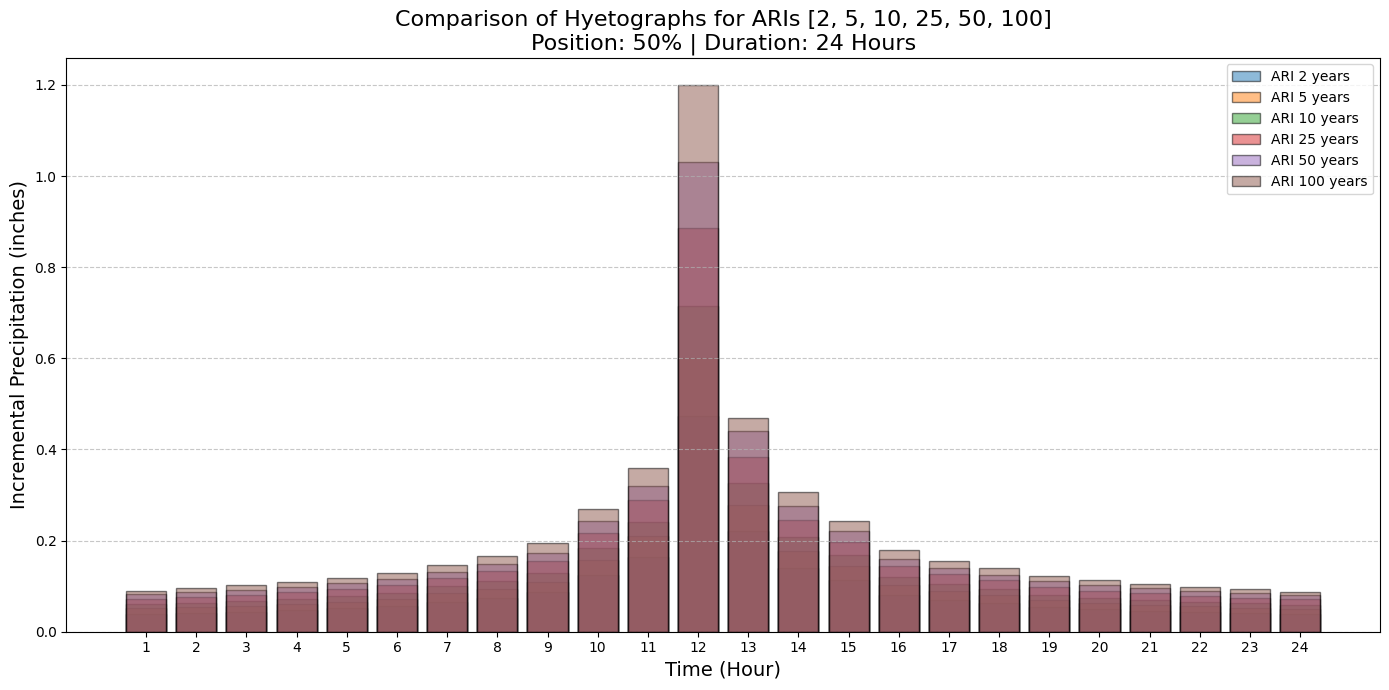

In [6]:

"""
Main function to run the entire AEP analysis process.
"""
# Set the paths and parameters
input_csv = 'data/PF_Depth_English_PDS_DavisCA.csv'  # Path to NOAA Atlas 14 data
output_dir = 'hyetographs'  # Directory for saving hyetographs
position_percent = 50  # Position percentage for the maximum incremental depth block
total_duration = 24  # Storm duration in hours
base_plan = "02"  # Base plan to clone

# Set the AEP events (return periods in years)
aep_events = [2, 5, 10, 25, 50, 100]

# Ensure the output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(f"Output directory is set to: {output_dir}")

#-------------------------------------------------------------------------
# Step 1: Generate hyetographs for each AEP event
#-------------------------------------------------------------------------
print("\nStep 1: Generating hyetographs for each AEP event...")

# Read precipitation data
df = read_precipitation_data(input_csv)
print("Successfully read the input CSV file.")

# Display the first few rows of the DataFrame to verify
print("\nPrecipitation Frequency Data from Atlas 14:")
display.display(df.head())

# Interpolate depths
D = interpolate_depths(df, total_duration)
print("Successfully interpolated precipitation depths.")

print("Array D with interpolated depths")
display.display(D)

# Compute incremental depths
inc_depths = compute_incremental_depths(D, total_duration)
print("Successfully computed incremental depths.")

# Show Incremental Depths
print("Array inc_depths Contents ")
display.display(inc_depths)

# Generate and save hyetographs for each AEP
hyetograph_files = {}
for ari in aep_events:
    ari_str = str(ari)
    if ari_str in inc_depths:
        hyetograph = generate_hyetograph(inc_depths[ari_str], position_percent, total_duration)
        file_path = save_hyetograph(hyetograph, ari_str, output_dir, position_percent, total_duration)
        hyetograph_files[ari_str] = file_path
    else:
        print(f"Warning: ARI {ari_str} not found in the data. Skipping.")

print("\nAll hyetographs have been generated and saved.")

# Plot the hyetographs for comparison
plot_multiple_hyetographs(aep_events, position_percent, total_duration, output_dir)


In [7]:
#-------------------------------------------------------------------------
# Initialize the HEC-RAS project
#-------------------------------------------------------------------------
print("\nStep 2: Initializing the HEC-RAS ras...")

# Use the project_path from Cell 6 (extracted with suffix)
# project_path is already defined from RasExamples.extract_project() above

# Initialize the RAS project
init_ras_project(project_path, RAS_VERSION)
print(f"Initialized HEC-RAS project: {ras.project_name}")

# Display the existing plans
print("\nExisting plans in the project:")
display.display(ras.plan_df)

2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap



Step 2: Initializing the HEC-RAS ras...
Initialized HEC-RAS project: DavisStormSystem

Existing plans in the project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,None,02,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady


In [8]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,None,02,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...,Unsteady


In [9]:
# Display unsteady_df - note: geometry_number column has been REMOVED
# This column was incorrectly appearing before; it only belongs in plan_df
print("Columns in unsteady_df:")
print(list(ras.unsteady_df.columns))
print()

# Verify geometry_number is NOT in unsteady_df
if 'geometry_number' not in ras.unsteady_df.columns:
    print("CORRECT: geometry_number is NOT in unsteady_df (only in plan_df)")
else:
    print("WARNING: geometry_number still in unsteady_df")
print()

ras.unsteady_df

Columns in unsteady_df:
['unsteady_number', 'full_path', 'Flow Title', 'Program Version', 'Use Restart', 'Precipitation Mode', 'Wind Mode', 'Met BC=Precipitation|Mode', 'Met BC=Evapotranspiration|Mode', 'Met BC=Precipitation|Expanded View', 'Met BC=Precipitation|Constant Units', 'Met BC=Precipitation|Gridded Source']

CORRECT: geometry_number is NOT in unsteady_df (only in plan_df)



,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,01,C:\GH\ras-commander\examples\example_projects\...,Full System Rain w/ Pump,6.60,0,Disable,No Wind Forces,Constant,None,-1,in/hr,DSS


In [10]:
# Display boundaries_df - Precipitation Hydrograph is now parsed by default!
# The hydrograph_values column contains the actual precipitation data
print(f"Found {len(ras.boundaries_df)} boundary conditions:")
print()

# Show key columns for boundary conditions
display_cols = ['unsteady_number', 'boundary_condition_number', 'bc_type', 
                'storage_area_name', 'hydrograph_type', 'hydrograph_num_values', 'Interval']
print(ras.boundaries_df[display_cols])
print()

# Get Precipitation Hydrograph data directly from boundaries_df
precip_bcs = ras.boundaries_df[ras.boundaries_df['bc_type'] == 'Precipitation Hydrograph']
if not precip_bcs.empty:
    print(f"Found {len(precip_bcs)} Precipitation Hydrograph boundary condition(s):")
    for idx, row in precip_bcs.iterrows():
        print(f"\n  Boundary #{row['boundary_condition_number']}:")
        print(f"    Storage Area: {row['storage_area_name']}")
        print(f"    Interval: {row['Interval']}")
        print(f"    Number of values: {row['hydrograph_num_values']}")
        
        # Get the hydrograph values directly from boundaries_df
        if 'hydrograph_values' in row and row['hydrograph_values']:
            values = row['hydrograph_values']
            print(f"    Hydrograph values: {values}")
            
            # Convert to numeric for analysis
            numeric_values = [float(v) for v in values]
            print(f"    Min: {min(numeric_values):.4f}, Max: {max(numeric_values):.4f}, Sum: {sum(numeric_values):.4f}")

Found 2 boundary conditions:

  unsteady_number  boundary_condition_number                   bc_type  \
0              01                          1              Normal Depth   
1              01                          2  Precipitation Hydrograph   

  storage_area_name           hydrograph_type  hydrograph_num_values Interval  
0                                        None                      0      NaN  
1                    Precipitation Hydrograph                     21    1HOUR  

Found 1 Precipitation Hydrograph boundary condition(s):

  Boundary #2:
    Storage Area: 
    Interval: 1HOUR
    Number of values: 21
    Hydrograph values: ['.1', '.1', '.1', '.25', '.25', '.25', '.25', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
    Min: 0.0000, Max: 0.2500, Sum: 1.3000


In [11]:
# Get the path to unsteady flow file associated with Unsteady Number "01"
unsteady_file = RasPlan.get_unsteady_path("01")
print(f"Unsteady flow file path: {unsteady_file}")

Unsteady flow file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01


In [12]:
unsteady_file

'C:\\GH\\ras-commander\\examples\\example_projects\\Davis_30_build_aep_storms\\DavisStormSystem.u01'

### Alternative Method: Using RasUnsteady.extract_boundary_and_tables()

The cell below demonstrates an alternative way to extract boundary conditions and their table data. This method provides more detailed control and returns nested DataFrames in the Tables column.

```python
# Extract boundary conditions and tables - includes Precipitation Hydrograph data
boundaries_df = RasUnsteady.extract_boundary_and_tables(unsteady_file)
print(f"Extracted {len(boundaries_df)} boundary conditions from the unsteady flow file.")

# Show which boundaries have table data
for idx, row in boundaries_df.iterrows():
    tables = row.get('Tables', {})
    storage_area = row.get('Storage Area Name', 'N/A')
    print(f"Boundary {idx + 1} (Storage Area: {storage_area}):")
    if tables:
        for table_name, table_df in tables.items():
            print(f"  - {table_name}: {len(table_df)} values")
            print(f"    Values: {table_df['Value'].tolist()}")
    else:
        print(f"  - No table data (likely a Normal Depth or other non-hydrograph BC)")
```

### Alternative Method: Using RasUnsteady.extract_tables()

This method extracts all tables from an unsteady file as a dictionary of DataFrames. It's useful when you need just the raw table data without boundary location information.

```python
# Use RasUnsteady.extract_tables() to get detailed precipitation hydrograph values
tables = RasUnsteady.extract_tables(unsteady_file)
print(f"Tables found in unsteady file:")
for table_name, df in tables.items():
    print(f"  - {table_name}: {len(df)} values")

# Display the Precipitation Hydrograph values
if 'Precipitation Hydrograph=' in tables:
    print("\nPrecipitation Hydrograph Values (inches):")
    precip_df = tables['Precipitation Hydrograph=']
    print(f"  Total values: {len(precip_df)}")
    print(f"  Values: {precip_df['Value'].tolist()}")
```

In [13]:
# Display the contents of Unsteady File
with open(unsteady_file, 'r') as f:
    unsteady_contents = f.read()
print(f"Contents of unsteady flow file {unsteady_file}:")
print("-" * 80)
print(unsteady_contents)
print("-" * 80)

Contents of unsteady flow file C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01:
--------------------------------------------------------------------------------
Flow Title=Full System Rain w/ Pump
Program Version=6.60
Use Restart= 0 
Boundary Location=                ,                ,        ,        ,                ,DS Channel      ,                ,DS Normal                       ,                                
Friction Slope=0.003,0
Boundary Location=                ,                ,        ,        ,                ,area2           ,                ,                                ,                                
Interval=1HOUR
Precipitation Hydrograph= 21 
      .1      .1      .1     .25     .25     .25     .25       0       0       0
       0       0       0       0       0       0       0       0       0       0
       0
DSS Path=
Use DSS=False
Use Fixed Start Time=False
Fixed Start Date/Time=,
Is Critical Boundary=False
Critic

### To implement AEP event hydrographs, we will edit the Precipitation Hydrograph table
We will need to edit both the number of values, as well as replacing the existing fixed-width table.  

#### Define HEC-RAS Plan and Unsteady Flow File Functions

These functions handle creating HEC-RAS plan files and unsteady flow files for each AEP event. They apply the generated hyetographs to the boundary conditions.

In [14]:
def create_plan_for_aep(base_plan, aep_years, duration_hours, hyetograph_file, project):
    """
    Creates a new plan for a specific AEP event.
    """
    # Create plan name and short ID
    plan_name = f"{aep_years}YR-{duration_hours}HR"
    
    print(f"Creating new plan '{plan_name}'...")
    
    # Clone the base plan
    new_plan_number = RasPlan.clone_plan(base_plan, new_shortid=plan_name, ras_object=project)
    print(f"Created new plan: {new_plan_number}")
    
    # Clone the unsteady flow file from the base plan
    base_unsteady = None
    for _, row in project.plan_df.iterrows():
        if row['plan_number'] == base_plan:
            base_unsteady = row.get('unsteady_number', None)
            
    if base_unsteady is None:
        raise ValueError(f"Could not find unsteady flow file for base plan {base_plan}")

    
    new_unsteady_number = RasPlan.clone_unsteady(base_unsteady, ras_object=project)
    print(f"Created new unsteady flow file: {new_unsteady_number}")
    
    # Update the unsteady flow file with the hyetograph data
    unsteady_file_path = RasPlan.get_unsteady_path(new_unsteady_number, ras_object=project)
    
    
    # Update the flow title to reflect the AEP event
    new_title = f"{aep_years}YR-{duration_hours}HR Storm"
    RasUnsteady.update_flow_title(unsteady_file_path, new_title, ras_object=project)
    print(f"Updated unsteady flow title to: {new_title}")
    
    # Modify the unsteady flow file with the hyetograph data
    success = modify_unsteady_flow_with_hyetograph(unsteady_file_path, hyetograph_file, project)
    if success:
        print(f"Successfully applied hyetograph data from {hyetograph_file} to unsteady flow file")
    else:
        print(f"Warning: Failed to apply hyetograph data. Unsteady flow file may need manual modification.")
    
    # Assign the unsteady flow file to the plan
    RasPlan.set_unsteady(new_plan_number, new_unsteady_number, ras_object=project)
    print(f"Assigned unsteady flow file {new_unsteady_number} to plan {new_plan_number}")
    # Return the plan and unsteady numbers
    return new_plan_number, new_unsteady_number

In [15]:
def modify_unsteady_flow_with_hyetograph(unsteady_file_path, hyetograph_file, project):
    """
    Modifies an unsteady flow file to incorporate hyetograph data as precipitation.
    
    Parameters:
    - unsteady_file_path: Path to the unsteady flow file
    - hyetograph_file: Path to the hyetograph data CSV
    - project: RAS project object
    
    Returns:
    - Boolean indicating success
    """
    # Read the hyetograph data
    hyetograph_df = pd.read_csv(hyetograph_file)
    print(f"Loaded hyetograph from {hyetograph_file} with {len(hyetograph_df)} values")

    # Read the unsteady flow file
    with open(unsteady_file_path, 'r') as file:
        lines = file.readlines()

    # Find the sections that need to be modified
    precip_hydrograph_index = None

    for i, line in enumerate(lines):
        if line.startswith("Precipitation Hydrograph="):
            precip_hydrograph_index = i
            break

    if precip_hydrograph_index is None:
        print("Cannot find Precipitation Hydrograph section in unsteady file.")
        return False

    # Get the time interval from the hyetograph
    time_interval = "1HOUR"  # Default
    if "Time_hour" in hyetograph_df.columns and len(hyetograph_df) > 1:
        hour_diff = hyetograph_df["Time_hour"].iloc[1] - hyetograph_df["Time_hour"].iloc[0]
        time_interval = f"{int(hour_diff)}HOUR" if hour_diff >= 1 else f"{int(hour_diff*60)}MIN"

    # Format the precipitation values for the hydrograph
    precipitation_values = hyetograph_df["Precipitation_in"].values

    # Create the Precipitation Hydrograph line
    precip_line = f"Precipitation Hydrograph= {len(precipitation_values)} \n"

    # Format the values in groups of 10 per line
    value_lines = []
    for i in range(0, len(precipitation_values), 10):
        row_values = precipitation_values[i:i+10]
        row_line = "".join([f"{value:8.2f}" for value in row_values]) + "\n"
        value_lines.append(row_line)

    # Remove old hydrograph data - find end of current hydrograph
    current_line = precip_hydrograph_index + 1
    while current_line < len(lines) and not any(lines[current_line].startswith(prefix) for prefix in ["DSS Path=", "Use DSS=", "Use Fixed Start Time="]):
        current_line += 1

    # Replace the hydrograph section
    lines[precip_hydrograph_index:current_line] = [precip_line] + value_lines

    # Write the modified file back
    with open(unsteady_file_path, 'w') as file:
        file.writelines(lines)

    print(f"Successfully applied hyetograph data from {hyetograph_file} to unsteady flow file.")
    print(f"Added {len(precipitation_values)} precipitation values with interval {time_interval}")
    return True

In [16]:
#-------------------------------------------------------------------------
# Create new plans for each AEP event
#-------------------------------------------------------------------------
print("\nStep 3: Creating new plans for each AEP event...")

new_plan_numbers = []
plan_aep_mapping = {}  # Track mapping between plan numbers and AEP values

for ari in aep_events:
    ari_str = str(ari)
    if ari_str in hyetograph_files:
        # Create a new plan for this AEP event
        new_plan_number, _ = create_plan_for_aep(
            base_plan=base_plan,
            aep_years=ari_str,
            duration_hours=total_duration,
            hyetograph_file=hyetograph_files[ari_str],
            project=ras
        )
        new_plan_numbers.append(new_plan_number)
        plan_aep_mapping[new_plan_number] = ari_str

# Update plan titles and descriptions with AEP information
print("\nUpdating plan titles and descriptions...")
for plan_number, aep_years in plan_aep_mapping.items():
    # Set plan title with AEP interval
    plan_title = f"{aep_years}-Year AEP Storm"
    RasPlan.set_plan_title(plan_number, plan_title, ras_object=ras)
    
    # Set plan description explaining hyetograph was calculated by ras-commander
    plan_description = f"Annual Exceedance Probability (AEP) storm event with {aep_years}-year return period. The precipitation hyetograph was calculated by ras-commander using NOAA Atlas 14 data and the Alternating Block Method."
    RasPlan.update_plan_description(plan_number, plan_description, ras_object=ras)
    
    print(f"Updated plan {plan_number}: Title='{plan_title}'")

# Display the updated plans
print("\nUpdated plans in the project:")
display.display(ras.plan_df)

2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p01
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p01
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 01



Step 3: Creating new plans for each AEP event...
Creating new plan '2YR-24HR'...


2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u02
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u02
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 02
2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:15 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System R

Created new plan: 01
Created new unsteady flow file: 02
Updated unsteady flow title to: 2YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_2_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 02 to plan 01
Creating new plan '5YR-24HR'...


2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p03
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p03
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 03
2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u03
2025-12-29 07:14:15 - r

Created new plan: 03
Created new unsteady flow file: 03
Updated unsteady flow title to: 5YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_5_years_pos50pct_24hr.csv to unsteady flow file


2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p04
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p04
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 04
2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u04
2025-12-29 07:14:15 - r

Assigned unsteady flow file 03 to plan 03
Creating new plan '10YR-24HR'...
Created new plan: 04


2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 04
2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:15 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '10YR-24HR Storm'
2025-12-29 07:14:15 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u04


Created new unsteady flow file: 04


2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p05
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p05
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 05


Updated unsteady flow title to: 10YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_10_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 04 to plan 04
Creating new plan '25YR-24HR'...


2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u05
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u05
2025-12-29 07:14:15 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 05
2025-12-29 07:14:15 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:15 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System R

Created new plan: 05
Created new unsteady flow file: 05
Updated unsteady flow title to: 25YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_25_years_pos50pct_24hr.csv to unsteady flow file


2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p06
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p06
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 06
2025-12-29 07:14:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u06
2025-12-29 07:14:16 - r

Assigned unsteady flow file 05 to plan 05
Creating new plan '50YR-24HR'...
Created new plan: 06


2025-12-29 07:14:16 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '50YR-24HR Storm'
2025-12-29 07:14:16 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u06
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p07
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p07
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Project file updated with new Plan entry: 07
2025-12-29 07:14:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_

Created new unsteady flow file: 06
Updated unsteady flow title to: 50YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_50_years_pos50pct_24hr.csv to unsteady flow file
Assigned unsteady flow file 06 to plan 06
Creating new plan '100YR-24HR'...


2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - File cloned from C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01 to C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u07
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u07
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Project file updated with new Unsteady entry: 07
2025-12-29 07:14:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.rasmap
2025-12-29 07:14:16 - ras_commander.RasUnsteady - INFO - Updated Flow Title from 'Full System Rain w/ Pump' to '100YR-24HR Storm'
2025-12-29 07:14:16 - ras_commander.RasUnsteady - INFO - Applied Flow Title modification to C:\GH\ras-commander\examples\example_projects\Davis_30_bu

Created new plan: 07
Created new unsteady flow file: 07
Updated unsteady flow title to: 100YR-24HR Storm
Loaded hyetograph from hyetographs\hyetograph_ARI_100_years_pos50pct_24hr.csv with 24 values
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_100_years_pos50pct_24hr.csv to unsteady flow file.
Added 24 precipitation values with interval 1HOUR
Successfully applied hyetograph data from hyetographs\hyetograph_ARI_100_years_pos50pct_24hr.csv to unsteady flow file


2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p01
2025-12-29 07:14:16 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: 2-Year AEP Storm
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p03
2025-12-29 07:14:16 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: 5-Year AEP Storm
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p04
2025-12-29 07:14:16 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: 10-Year AEP Storm
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\Da

Assigned unsteady flow file 07 to plan 07

Updating plan titles and descriptions...
Updated plan 01: Title='2-Year AEP Storm'
Updated plan 03: Title='5-Year AEP Storm'
Updated plan 04: Title='10-Year AEP Storm'


2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p06
2025-12-29 07:14:16 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: 50-Year AEP Storm
2025-12-29 07:14:16 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p07
2025-12-29 07:14:16 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: 100-Year AEP Storm


Updated plan 05: Title='25-Year AEP Storm'
Updated plan 06: Title='50-Year AEP Storm'
Updated plan 07: Title='100-Year AEP Storm'

Updated plans in the project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,description,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,NaN,None,02,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
1,01,02,02,2-Year AEP Storm,6.60,2YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
2,03,03,02,5-Year AEP Storm,6.60,5YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,03,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
3,04,04,02,10-Year AEP Storm,6.60,10YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,04,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
4,05,05,02,25-Year AEP Storm,6.60,25YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,05,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
5,06,06,02,50-Year AEP Storm,6.60,50YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,06,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
6,07,07,02,100-Year AEP Storm,6.60,100YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,NaN,None,02,C:\GH\ras-commander\examples\example_projects\...,07,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...


In [17]:
# Get the path to unsteady flow file associated with Unsteady Number "02"
unsteady_file_rev = RasPlan.get_unsteady_path("02")
print(f"Unsteady flow file path: {unsteady_file_rev}")

Unsteady flow file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u02


In [18]:
unsteady_file_rev

'C:\\GH\\ras-commander\\examples\\example_projects\\Davis_30_build_aep_storms\\DavisStormSystem.u02'

In [19]:
with open(unsteady_file_rev, 'r') as f:
    unsteady_contents_rev = f.read()
print(f"Contents of unsteady flow file for plan 02 ({unsteady_file_rev}):")
print("-" * 80)
print(unsteady_contents_rev)
print("-" * 80)

Contents of unsteady flow file for plan 02 (C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u02):
--------------------------------------------------------------------------------
Flow Title=2YR-24HR Storm
Program Version=6.60
Use Restart= 0 
Boundary Location=                ,                ,        ,        ,                ,DS Channel      ,                ,DS Normal                       ,                                
Friction Slope=0.003,0
Boundary Location=                ,                ,        ,        ,                ,area2           ,                ,                                ,                                
Interval=1HOUR
Precipitation Hydrograph= 24 
    0.04    0.04    0.04    0.05    0.05    0.06    0.07    0.07    0.09    0.12
    0.17    0.47    0.22    0.14    0.11    0.08    0.07    0.06    0.05    0.05
    0.05    0.04    0.04    0.04
DSS Path=
Use DSS=False
Use Fixed Start Time=False
Fixed Start Date/Time=,
Is Cr

In [20]:
import difflib

def show_file_diff(file1_path, file2_path, context_lines=3):
    """
    Shows the differences between two files with context.
    
    Parameters:
    - file1_path: Path to the first file
    - file2_path: Path to the second file
    - context_lines: Number of context lines to show around differences
    """
    # Read the file contents
    with open(file1_path, 'r') as file1:
        file1_lines = file1.readlines()
    
    with open(file2_path, 'r') as file2:
        file2_lines = file2.readlines()
    
    # Create a differ object
    differ = difflib.unified_diff(
        file1_lines, 
        file2_lines,
        fromfile=str(file1_path),
        tofile=str(file2_path),
        n=context_lines
    )
    
    # Convert differ output to a string
    diff_text = ''.join(differ)
    
    # If no differences found
    if not diff_text:
        print(f"No differences found between {file1_path} and {file2_path}")
        return
    
    # Print the differences
    print(f"Differences between {file1_path} and {file2_path}:")
    print("-" * 80)
    print(diff_text)
    print("-" * 80)
    
    # Count added, removed, and modified lines
    added = sum(1 for line in diff_text.splitlines() if line.startswith('+') and not line.startswith('+++'))
    removed = sum(1 for line in diff_text.splitlines() if line.startswith('-') and not line.startswith('---'))
    
    print(f"Summary: {added} additions, {removed} removals")

# Show differences between the unsteady flow files
if 'unsteady_file' in locals() and 'unsteady_file_rev' in locals():
    show_file_diff(unsteady_file, unsteady_file_rev)
else:
    print("Error: One or both unsteady flow file variables not defined.")
    print("Please run the cells that define unsteady_file and unsteady_file_rev first.")

Differences between C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01 and C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u02:
--------------------------------------------------------------------------------
--- C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01
+++ C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u02
@@ -1,14 +1,14 @@
-Flow Title=Full System Rain w/ Pump
+Flow Title=2YR-24HR Storm
 Program Version=6.60
 Use Restart= 0 
 Boundary Location=                ,                ,        ,        ,                ,DS Channel      ,                ,DS Normal                       ,                                
 Friction Slope=0.003,0
 Boundary Location=                ,                ,        ,        ,                ,area2           ,                ,                                ,                          

#### Define Parallel Execution and Results Analysis Functions

These functions manage parallel plan execution with resource optimization and extract, analyze, and visualize the results.

## Debugging: Test Single Plan Execution

Before running all plans in parallel, we'll run a single plan with verbose logging to verify the HEC-RAS computation works correctly. This helps identify issues early.

In [21]:
#-------------------------------------------------------------------------
# DEBUGGING: Enable verbose logging and test single plan execution
#-------------------------------------------------------------------------
import logging
from ras_commander.callbacks import ConsoleCallback, FileLoggerCallback
from pathlib import Path

# Enable DEBUG level logging for more detailed output
logging.getLogger('ras_commander').setLevel(logging.DEBUG)

# Create a logs directory for execution logs
logs_dir = Path('execution_logs')
logs_dir.mkdir(exist_ok=True)

# Create verbose callbacks
console_callback = ConsoleCallback(verbose=True)  # Print all HEC-RAS messages
file_callback = FileLoggerCallback(output_dir=logs_dir)  # Save to log files

print("DEBUG: Logging level set to DEBUG")
print(f"DEBUG: Log files will be saved to: {logs_dir.absolute()}")
print(f"DEBUG: Plans created: {new_plan_numbers}")
print(f"DEBUG: Will test single plan: {new_plan_numbers[0] if new_plan_numbers else 'None'}")

2025-12-29 07:14:16 - ras_commander.callbacks - INFO - FileLoggerCallback initialized: execution_logs


DEBUG: Logging level set to DEBUG
DEBUG: Log files will be saved to: c:\GH\ras-commander\examples\execution_logs
DEBUG: Plans created: ['01', '03', '04', '05', '06', '07']
DEBUG: Will test single plan: 01


In [22]:
#-------------------------------------------------------------------------
# DEBUGGING: Run single test plan with verbose output
#-------------------------------------------------------------------------
print("="*80)
print("SINGLE PLAN TEST EXECUTION")
print("="*80)

if new_plan_numbers:
    test_plan = new_plan_numbers[0]
    print(f"\nTesting execution of plan: {test_plan}")
    
    # Create a test folder for single plan execution
    test_folder = Path(project_path) / "test_single_plan"
    print(f"Test folder: {test_folder}")
    
    # Run single plan with verbose callback and verification
    result = RasCmdr.compute_plan(
        plan_number=test_plan,
        dest_folder=test_folder,
        clear_geompre=True,
        num_cores=NUM_CORES,
        overwrite_dest=True,
        stream_callback=console_callback,  # Verbose console output
        ras_object=ras
    )
    
    print(f"\n{'='*80}")
    print(f"RESULT: Plan {test_plan} execution returned: {result}")
    print(f"{'='*80}")
else:
    print("ERROR: No plans were created. Cannot run test.")

2025-12-29 07:14:16 - ras_commander.RasCmdr - DEBUG - Calling compute_plan
2025-12-29 07:14:16 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Finished check_initialized


SINGLE PLAN TEST EXECUTION

Testing execution of plan: 01
Test folder: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan


2025-12-29 07:14:16 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Calling initialize
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Calling find_ras_prj
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Finished find_ras_prj
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Calling _load_project_data
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Calling _format_dataframe
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Finished _format_dataframe
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Finished _get_prj_entries
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:14:16 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30

[Plan 01] Starting execution...
[Plan 01] Command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\DavisStormSystem.prj" "C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\DavisStormSystem.p01"


2025-12-29 07:14:16 - ras_commander.BcoMonitor - INFO - Monitoring DavisStormSystem.bco01 for 'Starting Unsteady Flow Computations' signal...


[Plan 01] HEC-RAS - River Analysis System
[Plan 01] Project File:  C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\DavisStormSystem.prj
[Plan 01] Project Name:  DavisStormSystem
[Plan 01] Plan Name:     2-Year AEP Storm
[Plan 01] Short ID:      2YR-24HR
[Plan 01] Starting Time:   10Jan2000 1200
[Plan 01] Ending Time:     11Jan2000 2400
[Plan 01] ################################################
[Plan 01] #                                              #
[Plan 01] #                                              #
[Plan 01] #       1D and 2D Unsteady Flow Module         #
[Plan 01] #                                              #
[Plan 01] #                                              #
[Plan 01] #          HEC-RAS 6.6 September 2024          #
[Plan 01] #                                              #
[Plan 01] #             29DEC25 at 07:14:21              #
[Plan 01] #                                              #
[Plan 01] #####################

2025-12-29 07:15:15 - ras_commander.BcoMonitor - INFO - Process exited with code 0
2025-12-29 07:15:15 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01
2025-12-29 07:15:15 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 58.12 seconds


[Plan 01] SUCCESS in 58.1s


2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling get_plan_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p01 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p03 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_buil


RESULT: Plan 01 execution returned: True


In [23]:
#-------------------------------------------------------------------------
# DEBUGGING: Check HDF file and compute output
#-------------------------------------------------------------------------
import os

print("="*80)
print("HDF FILE AND COMPUTE OUTPUT CHECK")
print("="*80)

if new_plan_numbers:
    test_plan = new_plan_numbers[0]
    test_folder = Path(project_path) / "test_single_plan"
    
    # List all files in the test folder
    print(f"\nFiles in test folder ({test_folder}):")
    if test_folder.exists():
        for root, dirs, files in os.walk(test_folder):
            for f in files:
                filepath = Path(root) / f
                size = filepath.stat().st_size
                print(f"  {f} ({size:,} bytes)")
    else:
        print("  TEST FOLDER NOT FOUND!")
    
    # Look for HDF files
    print(f"\n{'='*40}")
    print("HDF File Search:")
    hdf_files = list(test_folder.glob("**/*.hdf")) if test_folder.exists() else []
    if hdf_files:
        print(f"Found {len(hdf_files)} HDF file(s):")
        for hdf in hdf_files:
            size = hdf.stat().st_size / 1024 / 1024  # MB
            print(f"  {hdf.name} ({size:.2f} MB)")
            
            # Try to read compute messages from the HDF file
            try:
                messages = HdfResultsPlan.get_compute_messages(hdf)
                print(f"\n  Compute Messages from {hdf.name}:")
                print("-"*60)
                if messages:
                    # Display first and last messages
                    if len(messages) > 10:
                        print("  First 5 messages:")
                        for msg in messages[:5]:
                            print(f"    {msg}")
                        print(f"  ... ({len(messages) - 10} more messages) ...")
                        print("  Last 5 messages:")
                        for msg in messages[-5:]:
                            print(f"    {msg}")
                    else:
                        for msg in messages:
                            print(f"    {msg}")
                else:
                    print("  No compute messages found in HDF file")
                print("-"*60)
            except Exception as e:
                print(f"  Error reading compute messages: {e}")
    else:
        print("  NO HDF FILES FOUND!")
        print("\n  This indicates HEC-RAS did not complete computation successfully.")
        print("  Possible causes:")
        print("    1. Geometry preprocessing failure")
        print("    2. Computation instabilities")
        print("    3. Invalid boundary conditions")
        print("    4. Missing required files")
    
    # Check for .bco (computation log) files
    print(f"\n{'='*40}")
    print("Computation Log (.bco) Files:")
    bco_files = list(test_folder.glob("**/*.bco")) if test_folder.exists() else []
    if bco_files:
        for bco in bco_files:
            print(f"\n  {bco.name}:")
            with open(bco, 'r') as f:
                content = f.read()
                lines = content.strip().split('\n')
                if len(lines) > 20:
                    print("  First 10 lines:")
                    for line in lines[:10]:
                        print(f"    {line}")
                    print(f"  ... ({len(lines) - 20} more lines) ...")
                    print("  Last 10 lines:")
                    for line in lines[-10:]:
                        print(f"    {line}")
                else:
                    for line in lines:
                        print(f"    {line}")
    else:
        print("  No .bco files found (computation log not generated)")

2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Calling get_compute_messages
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\DavisStormSystem.g02.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\DavisStormSystem.g02.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\DavisStormSystem.g02.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - WARNING - Compute Messages not found in HDF at 'Results/Summary/Compute Messages (text)', falling back to .txt file extraction
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - .txt file fal

HDF FILE AND COMPUTE OUTPUT CHECK

Files in test folder (C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan):
  DavisStormSystem.b01 (2,802 bytes)
  DavisStormSystem.b02 (2,749 bytes)
  DavisStormSystem.bco01 (3,733 bytes)
  DavisStormSystem.bco02 (3,697 bytes)
  DavisStormSystem.color_scales (80 bytes)
  DavisStormSystem.dss (2,709,800 bytes)
  DavisStormSystem.g02 (95,801 bytes)
  DavisStormSystem.g02.hdf (1,529,028 bytes)
  DavisStormSystem.ic.o01 (12,800 bytes)
  DavisStormSystem.ic.o02 (12,800 bytes)
  DavisStormSystem.p01 (9,761 bytes)
  DavisStormSystem.p01.hdf (18,383,671 bytes)
  DavisStormSystem.p02 (9,591 bytes)
  DavisStormSystem.p03 (9,758 bytes)
  DavisStormSystem.p04 (9,761 bytes)
  DavisStormSystem.p05 (9,761 bytes)
  DavisStormSystem.p06 (9,761 bytes)
  DavisStormSystem.p07 (9,764 bytes)
  DavisStormSystem.prj (780 bytes)
  DavisStormSystem.rasmap (23,951 bytes)
  DavisStormSystem.rasmap.backup (12,523 bytes)
  DavisStormSystem.u01

2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - No computation messages found in HDF or .txt sources for Terrain (1).hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Finished get_compute_messages
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Calling get_compute_messages
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\test_single_plan\DavisStormSystem.g02.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\test_single_plan\DavisStormSystem.g02.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\test_single_plan\Dav


  Compute Messages from Terrain (1).hdf:
------------------------------------------------------------
  No compute messages found in HDF file
------------------------------------------------------------
  DavisStormSystem.g02.hdf (1.46 MB)

  Compute Messages from DavisStormSystem.g02.hdf:
------------------------------------------------------------
  No compute messages found in HDF file
------------------------------------------------------------
  DavisStormSystem.u01.hdf (0.01 MB)


2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\test_single_plan\DavisStormSystem.u01.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - WARNING - Compute Messages not found in HDF at 'Results/Summary/Compute Messages (text)', falling back to .txt file extraction
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - .txt file fallback failed: Plan 'C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\test_single_plan\DavisStormSystem.u01.hdf' not found in project
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - No computation messages found in HDF or .txt sources for DavisStormSystem.u01.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Finished get_compute_messages
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Calling get_compu


  Compute Messages from DavisStormSystem.u01.hdf:
------------------------------------------------------------
  No compute messages found in HDF file
------------------------------------------------------------
  DavisStormSystem.u02.hdf (0.01 MB)


2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\test_single_plan\DavisStormSystem.u02.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - WARNING - Compute Messages not found in HDF at 'Results/Summary/Compute Messages (text)', falling back to .txt file extraction
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - .txt file fallback failed: Plan 'C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\test_single_plan\test_single_plan\DavisStormSystem.u02.hdf' not found in project
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - No computation messages found in HDF or .txt sources for DavisStormSystem.u02.hdf
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Finished get_compute_messages
2025-12-29 07:15:15 - ras_commander.hdf.HdfResultsPlan - DEBUG - Calling get_compu


  Compute Messages from DavisStormSystem.u02.hdf:
------------------------------------------------------------
  No compute messages found in HDF file
------------------------------------------------------------
  DavisStormSystem.u03.hdf (0.01 MB)

  Compute Messages from DavisStormSystem.u03.hdf:
------------------------------------------------------------
  No compute messages found in HDF file
------------------------------------------------------------
  DavisStormSystem.u04.hdf (0.01 MB)

  Compute Messages from DavisStormSystem.u04.hdf:
------------------------------------------------------------
  No compute messages found in HDF file
------------------------------------------------------------
  DavisStormSystem.u05.hdf (0.01 MB)

  Compute Messages from DavisStormSystem.u05.hdf:
------------------------------------------------------------
  No compute messages found in HDF file
------------------------------------------------------------
  DavisStormSystem.u06.hdf (0.01 MB)


## STOP: Review Test Results Before Continuing

**Review the test execution output above before proceeding.**

If the single plan test was successful:
- An HDF file should exist in the test folder
- Compute messages should show "Simulation completed" or similar success messages
- The result should return `True`

If the test failed:
- No HDF file found indicates the computation didn't complete
- Check the .bco file (if it exists) for error messages
- Review the plan file, unsteady flow file, and geometry for issues

**Common Issues:**
1. **No HDF generated**: Geometry preprocessing failed or boundary conditions invalid
2. **Computation instabilities**: Check interval settings and boundary condition values
3. **Missing files**: Verify all required geometry and flow files are present

**Only continue to parallel execution if the single plan test succeeds!**

In [24]:
#-------------------------------------------------------------------------
# DEBUGGING: Compare unsteady files - original vs AEP modified
#-------------------------------------------------------------------------
print("="*80)
print("UNSTEADY FILE COMPARISON")
print("="*80)

# Get original unsteady file (u01)
original_unsteady = RasPlan.get_unsteady_path("01", ras_object=ras)
print(f"\nOriginal unsteady file (base plan): {original_unsteady}")

# Get the first modified unsteady file
if new_plan_numbers:
    test_plan = new_plan_numbers[0]
    plan_info = ras.plan_df[ras.plan_df['plan_number'] == test_plan].iloc[0]
    modified_unsteady_num = plan_info.get('unsteady_number', plan_info.get('Flow File'))
    modified_unsteady = RasPlan.get_unsteady_path(modified_unsteady_num, ras_object=ras)
    print(f"Modified unsteady file (plan {test_plan}): {modified_unsteady}")
    
    # Read and compare precipitation hydrograph sections
    print(f"\n{'='*40}")
    print("Precipitation Hydrograph Comparison:")
    print("="*40)
    
    def extract_precip_hydrograph(filepath):
        """Extract precipitation hydrograph section from unsteady file."""
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        in_precip = False
        precip_lines = []
        for line in lines:
            if line.startswith("Precipitation Hydrograph="):
                in_precip = True
                precip_lines.append(line.strip())
            elif in_precip:
                if line.startswith("DSS Path=") or line.startswith("Use DSS="):
                    break
                precip_lines.append(line.strip())
        return precip_lines
    
    print("\nORIGINAL (base plan):")
    orig_precip = extract_precip_hydrograph(original_unsteady)
    for line in orig_precip[:5]:  # First 5 lines
        print(f"  {line}")
    if len(orig_precip) > 5:
        print(f"  ... ({len(orig_precip) - 5} more lines)")
    
    print("\nMODIFIED (AEP storm):")
    mod_precip = extract_precip_hydrograph(modified_unsteady)
    for line in mod_precip[:5]:  # First 5 lines
        print(f"  {line}")
    if len(mod_precip) > 5:
        print(f"  ... ({len(mod_precip) - 5} more lines)")
    
    # Parse and sum precipitation values
    def sum_precip(precip_lines):
        """Sum all precipitation values from the hydrograph."""
        values = []
        for line in precip_lines[1:]:  # Skip header
            parts = line.split()
            for p in parts:
                try:
                    values.append(float(p))
                except ValueError:
                    pass
        return sum(values), len(values)
    
    orig_sum, orig_count = sum_precip(orig_precip)
    mod_sum, mod_count = sum_precip(mod_precip)
    
    print(f"\n{'='*40}")
    print("Precipitation Summary:")
    print(f"  Original: {orig_count} values, total = {orig_sum:.4f} inches")
    print(f"  Modified: {mod_count} values, total = {mod_sum:.4f} inches")
    print("="*40)
else:
    print("ERROR: No plans created to compare")

2025-12-29 07:15:15 - ras_commander.RasPlan - DEBUG - Calling get_unsteady_path
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Calling normalize_ras_number
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Normalized RAS number '01' to '01'
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Finished normalize_ras_number
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling get_prj_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _format_dataframe
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished _format_dataframe
2025-12-29 07:15:15 - ras_com

UNSTEADY FILE COMPARISON

Original unsteady file (base plan): C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01
Modified unsteady file (plan 01): C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u02

Precipitation Hydrograph Comparison:

ORIGINAL (base plan):
  Precipitation Hydrograph= 21
  .1      .1      .1     .25     .25     .25     .25       0       0       0
  0       0       0       0       0       0       0       0       0       0
  0

MODIFIED (AEP storm):
  Precipitation Hydrograph= 24
  0.04    0.04    0.04    0.05    0.05    0.06    0.07    0.07    0.09    0.12
  0.17    0.47    0.22    0.14    0.11    0.08    0.07    0.06    0.05    0.05
  0.05    0.04    0.04    0.04

Precipitation Summary:
  Original: 21 values, total = 1.3000 inches
  Modified: 24 values, total = 2.2200 inches


In [25]:
def execute_plans_in_parallel(plan_numbers, project, max_workers=None, cores_per_worker=2):
    """
    Executes multiple plans in parallel.
    """
    # Calculate optimal number of workers if not provided
    if max_workers is None:
        physical_cores = psutil.cpu_count(logical=False)  # Physical cores only
        max_workers = max(1, physical_cores // cores_per_worker)
    
    print(f"Executing {len(plan_numbers)} plans in parallel with {max_workers} workers, " + 
          f"each using {cores_per_worker} cores...")
    
    # Create compute folder
    compute_folder = Path(project.project_folder) / "compute_aep_parallel"
    compute_folder.mkdir(parents=True, exist_ok=True)
    
    # Execute plans in parallel
    start_time = time.time()
    
    results = RasCmdr.compute_parallel(
        plan_number=plan_numbers,
        max_workers=max_workers,
        num_cores=cores_per_worker,
        dest_folder=compute_folder,
        clear_geompre=True,
        overwrite_dest=True,
        ras_object=project
    )
    
    end_time = time.time()
    total_duration = end_time - start_time
    
    print(f"Parallel execution completed in {total_duration:.2f} seconds")
    
    # Create a DataFrame from the execution results
    results_df = pd.DataFrame([
        {"Plan": plan, "Success": success}
        for plan, success in results.items()
    ])
    
    # Sort by plan number
    results_df = results_df.sort_values("Plan")
    
    print("\nExecution Results:")
    display.display(results_df)
    
    return results, compute_folder

In [26]:
# Get the path to unsteady flow file associated with Plan "01"
unsteady_file = RasPlan.get_unsteady_path("01")
print(f"Unsteady flow file path: {unsteady_file}")

2025-12-29 07:15:15 - ras_commander.RasPlan - DEBUG - Calling get_unsteady_path
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Calling normalize_ras_number
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Normalized RAS number '01' to '01'
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Finished normalize_ras_number
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling get_prj_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _format_dataframe
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished _format_dataframe
2025-12-29 07:15:15 - ras_com

Unsteady flow file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.u01


In [27]:
#-------------------------------------------------------------------------
# Execute all plans in parallel
#-------------------------------------------------------------------------

In [28]:
# Set computation parameters for better performance
for plan_number in new_plan_numbers:
    RasPlan.set_num_cores(plan_number, 2, ras_object=ras)
    print(f"Updated computation settings for plan {plan_number}")

# Update plan titles and descriptions with AEP information (if not already done)
# This ensures titles/descriptions are set even if Cell 24 wasn't run
if 'plan_aep_mapping' not in locals() or not plan_aep_mapping:
    # Reconstruct mapping from plan short IDs if available
    plan_aep_mapping = {}
    for plan_number in new_plan_numbers:
        try:
            short_id = RasPlan.get_shortid(plan_number, ras_object=ras)
            # Extract AEP years from short ID (e.g., "2YR-24HR" -> "2")
            if 'YR' in short_id:
                aep_years = short_id.split('YR')[0]
                plan_aep_mapping[plan_number] = aep_years
        except Exception as e:
            print(f"Warning: Could not extract AEP from plan {plan_number}: {e}")

# Update titles and descriptions
for plan_number, aep_years in plan_aep_mapping.items():
    # Set plan title with AEP interval
    plan_title = f"{aep_years}-Year AEP Storm"
    RasPlan.set_plan_title(plan_number, plan_title, ras_object=ras)
    
    # Set plan description explaining hyetograph was calculated by ras-commander
    plan_description = f"Annual Exceedance Probability (AEP) storm event with {aep_years}-year return period. The precipitation hyetograph was calculated by ras-commander using NOAA Atlas 14 data and the Alternating Block Method."
    RasPlan.update_plan_description(plan_number, plan_description, ras_object=ras)
    
    print(f"Updated plan {plan_number}: Title='{plan_title}'")

# Execute plans in parallel
results, compute_folder = execute_plans_in_parallel(
    plan_numbers=new_plan_numbers,
    project=ras
)

2025-12-29 07:15:15 - ras_commander.RasPlan - DEBUG - Calling set_num_cores
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Calling get_plan_path
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Calling normalize_ras_number
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Normalized RAS number '01' to '01'
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Finished normalize_ras_number
2025-12-29 07:15:15 - ras_commander.RasUtils - DEBUG - Normalized plan number to: 01
2025-12-29 07:15:15 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p01
2025-12-29

Updated computation settings for plan 01
Updated computation settings for plan 03
Updated computation settings for plan 04


2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling get_plan_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p01 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p03 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_buil

Updated computation settings for plan 05


2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p02 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p01 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p03 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p04 using utf-8 encoding
2025-12-29 07:15:15 - r

Updated computation settings for plan 06
Updated computation settings for plan 07


2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p04 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p05 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p06 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p07 using utf-8 encoding
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Calling _format_dataframe
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished _format_dataframe
2025-12-29 07:15:15 - ras_commander.RasPrj - DEBUG - Finished _get_prj_entries
2025-12-29 07:15:15 - 

Updated plan 01: Title='2-Year AEP Storm'
Updated plan 03: Title='5-Year AEP Storm'


2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Calling normalize_ras_number
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Normalized RAS number '04' to '04'
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Finished normalize_ras_number
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Normalized plan number to: 04
2025-12-29 07:15:16 - ras_commander.RasUtils - INFO - Constructed plan file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\DavisStormSystem.p04
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Finished get_plan_path
2025-12-29 07:15:16 - ras_commander.RasPlan - INFO - Updated Plan Title in plan file to: 10-Year AEP Storm
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Calling get_plan_entries
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Callin

Updated plan 04: Title='10-Year AEP Storm'


2025-12-29 07:15:16 - ras_commander.RasPlan - DEBUG - Finished get_plan_path
2025-12-29 07:15:16 - ras_commander.RasPlan - DEBUG - Finished update_plan_description
2025-12-29 07:15:16 - ras_commander.RasPlan - DEBUG - Calling set_plan_title
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Calling get_plan_path
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Calling normalize_ras_number
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Normalized RAS number '06' to '06'
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Finished normalize_ras_number
2025-12-29 07:15:16 - ras_commander.RasUtils - DEBUG - Normalized plan number to: 06
2025-12-29 07:15:16 

Updated plan 05: Title='25-Year AEP Storm'
Updated plan 06: Title='50-Year AEP Storm'


2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Finished get_plan_entries
2025-12-29 07:15:16 - ras_commander.RasPlan - DEBUG - Finished get_plan_path
2025-12-29 07:15:16 - ras_commander.RasPlan - DEBUG - Finished update_plan_description
2025-12-29 07:15:16 - ras_commander.RasCmdr - DEBUG - Calling compute_parallel
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Calling check_initialized
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Finished check_initialized
2025-12-29 07:15:16 - ras_commander.RasCmdr - INFO - Destination folder 'C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel' exists. Overwriting as per overwrite_dest=True.


Updated plan 07: Title='100-Year AEP Storm'
Executing 6 plans in parallel with 4 workers, each using 2 cores...


2025-12-29 07:15:16 - ras_commander.RasCmdr - INFO - Copied project folder to destination: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel
2025-12-29 07:15:16 - ras_commander.RasCmdr - INFO - Filtered plans to execute: ['01', '03', '04', '05', '06', '07']
2025-12-29 07:15:16 - ras_commander.RasCmdr - INFO - Adjusted max_workers to 4 based on the number of plans to compute: 6
2025-12-29 07:15:16 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel [Worker 1]
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Calling init_ras_project
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - User provided folder path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel [Worker 1]
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - Calling get_ras_exe
2025-12-29 07:15:16 - ras_commander.RasPrj - DEBUG - HEC-RAS e

Parallel execution completed in 213.35 seconds

Execution Results:


,Plan,Success
0,01,True
1,03,True
2,04,True
3,05,True
4,06,True
5,07,True


print("\nStep 4: Executing all plans in parallel...")

results, compute_folder = execute_plans_in_parallel(
    plan_numbers=new_plan_numbers,
    project=ras
)

In [29]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,description,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,NaN,None,02,C:\GH\ras-commander\examples\example_projects\...,01,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
1,01,02,02,2-Year AEP Storm,6.60,2YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,02,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
2,03,03,02,5-Year AEP Storm,6.60,5YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,03,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
3,04,04,02,10-Year AEP Storm,6.60,10YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,04,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
4,05,05,02,25-Year AEP Storm,6.60,25YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,05,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
5,06,06,02,50-Year AEP Storm,6.60,50YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,06,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...
6,07,07,02,100-Year AEP Storm,6.60,100YR-24HR,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,-1,...,1,PARDISO (Direct),area2,Annual Exceedance Probability (AEP) storm even...,None,02,C:\GH\ras-commander\examples\example_projects\...,07,C:\GH\ras-commander\examples\example_projects\...,C:\GH\ras-commander\examples\example_projects\...


In [30]:
#-------------------------------------------------------------------------
# NOTE: HDF files are in compute_folder, not project root!
# The compute_parallel() function places results in the dest_folder parameter
#-------------------------------------------------------------------------
from ras_commander import get_logger

logger = get_logger(__name__)

print(f"Looking for HDF files in: {compute_folder}")

# List HDF files in compute folder
hdf_files = list(compute_folder.glob("*.hdf"))
plan_hdf_files = [f for f in hdf_files if f.name.startswith("DavisStormSystem.p")]
print(f"Found {len(plan_hdf_files)} plan HDF files:")
for hdf in plan_hdf_files:
    size_mb = hdf.stat().st_size / 1024 / 1024
    print(f"  {hdf.name} ({size_mb:.2f} MB)")

# Read compute messages from the first HDF file
if plan_hdf_files:
    test_hdf = plan_hdf_files[0]
    print(f"\n--- Compute messages from {test_hdf.name} ---")
    try:
        messages = HdfResultsPlan.get_compute_messages(test_hdf)
        if messages:
            print(f"Total messages: {len(messages)}")
            print("Last 10 messages:")
            for msg in messages[-10:]:
                print(f"  {msg}")
        else:
            print("No compute messages in HDF file")
    except Exception as e:
        logger.error(f"Error reading compute messages: {e}")

2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - DEBUG - Calling get_compute_messages
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 1510 characters from HDF
2025-12-29

Looking for HDF files in: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel
Found 6 plan HDF files:
  DavisStormSystem.p01.hdf (17.54 MB)
  DavisStormSystem.p03.hdf (17.21 MB)
  DavisStormSystem.p04.hdf (16.99 MB)
  DavisStormSystem.p05.hdf (16.84 MB)
  DavisStormSystem.p06.hdf (16.71 MB)
  DavisStormSystem.p07.hdf (16.60 MB)

--- Compute messages from DavisStormSystem.p01.hdf ---
Total messages: 1510
Last 10 messages:
  e
  s
  s
  	
  9
  8
  0
  x
  
  



In [31]:
#-------------------------------------------------------------------------
# Read runtime data from the first executed plan
#-------------------------------------------------------------------------
if plan_hdf_files:
    test_hdf = plan_hdf_files[0]
    print(f"Reading runtime data from: {test_hdf.name}")
    try:
        runtime_df = HdfResultsPlan.get_runtime_data(test_hdf)
        print("\nRuntime Data:")
        display.display(runtime_df)
    except Exception as e:
        print(f"Error reading runtime data: {e}")
else:
    print("No HDF files found - cannot read runtime data")

2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Plan Name: 2-Year AEP Storm
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0


Reading runtime data from: DavisStormSystem.p01.hdf

Runtime Data:


,Plan Name,File Name,Simulation Start Time,Simulation End Time,Simulation Duration (s),Simulation Time (hr),Completing Geometry (hr),Preprocessing Geometry (hr),Completing Event Conditions (hr),Unsteady Flow Computations (hr),Complete Process (hr),Unsteady Flow Speed (hr/hr),Complete Process Speed (hr/hr)
0,2-Year AEP Storm,DavisStormSystem.p01.hdf,2000-01-10 12:00:00,2000-01-12,129600.0,36.0,N/A,0.000044,N/A,0.035612,0.036732,1010.896781,980.073354


In [32]:
runtime_df

,Plan Name,File Name,Simulation Start Time,Simulation End Time,Simulation Duration (s),Simulation Time (hr),Completing Geometry (hr),Preprocessing Geometry (hr),Completing Event Conditions (hr),Unsteady Flow Computations (hr),Complete Process (hr),Unsteady Flow Speed (hr/hr),Complete Process Speed (hr/hr)
0,2-Year AEP Storm,DavisStormSystem.p01.hdf,2000-01-10 12:00:00,2000-01-12,129600.0,36.0,N/A,0.000044,N/A,0.035612,0.036732,1010.896781,980.073354


In [33]:
# Extract pipe flow data from the first executed plan HDF
# NOTE: HDF files are in compute_folder, use full path
if plan_hdf_files:
    test_hdf = plan_hdf_files[0]
    print(f"Reading pipe flow from: {test_hdf}")
    pipe_flow_ds = HdfPipe.get_pipe_network_timeseries(test_hdf, variable="Pipes/Pipe Flow DS")
    print(f"Pipe flow data shape: {pipe_flow_ds.shape if pipe_flow_ds is not None else 'None'}")
else:
    print("No HDF files available")
    pipe_flow_ds = None

2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries


Reading pipe flow from: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
Pipe flow data shape: (217, 132)


In [34]:
pipe_flow_ds 

<xarray.DataArray 'Pipes/Pipe Flow DS' (time: 217, location: 132)> Size: 115kB
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       ...,
       [ 4.9451767e+01,  1.7438200e+01,  4.9452591e+01, ...,
         1.0395306e-03,  4.2476933e-04,  2.2357248e-03],
       [ 4.9437492e+01,  1.7434511e+01,  4.9438305e+01, ...,
         1.0172215e-03,  4.1209065e-04,  2.1950868e-03],
       [ 4.9425026e+01,  1.7433273e+01,  4.9425823e+01, ...,
         1.0014094e-03,  4.0004018e-04,  2.3543425e-03]],
      shape=(217, 132), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 125 126 127 128 129 130 131
Attributes:
    units:     ft^3/s
    variable:  Pipes/Pipe Flow DS

In [35]:
# Extract node water surface data from the first executed plan HDF
# NOTE: HDF files are in compute_folder, use full path
if plan_hdf_files:
    test_hdf = plan_hdf_files[0]
    print(f"Reading node water surface from: {test_hdf}")
    node_ws = HdfPipe.get_pipe_network_timeseries(test_hdf, variable="Nodes/Water Surface")
    print(f"Node WS data shape: {node_ws.shape if node_ws is not None else 'None'}")
else:
    print("No HDF files available")
    node_ws = None

2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries


Reading node water surface from: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
Node WS data shape: (217, 133)


In [36]:
node_ws

<xarray.DataArray 'Nodes/Water Surface' (time: 217, location: 133)> Size: 115kB
array([[26.98    , 25.79    , 28.87    , ..., 41.64    , 42.23    ,
        38.      ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       ...,
       [38.54893 , 38.38718 , 38.71159 , ..., 40.812107, 42.008835,
        38.719715],
       [38.53519 , 38.373535, 38.697945, ..., 40.811977, 42.008705,
        38.705997],
       [38.52161 , 38.360035, 38.684475, ..., 40.81185 , 42.008583,
        38.69245 ]], shape=(217, 133), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 126 127 128 129 130 131 132
Attributes:
    units:     ft
    variable:  Nodes/Water Surface

In [37]:
def analyze_results(results, compute_folder, project):
    """
    Analyzes the results from multiple plans.
    """
    print("Analyzing results from parallel execution...")
    
    # Initialize a RAS project in the compute folder
    compute_project = RasPrj()
    compute_project = init_ras_project(compute_folder, RAS_VERSION, ras_object=compute_project)
    print(f"Initialized compute project: {compute_project.project_name}")
    
    # Check which plans have results
    plans_with_results = compute_project.plan_df[compute_project.plan_df['HDF_Results_Path'].notna()]
    print(f"\nFound {len(plans_with_results)} plans with results:")
    display.display(plans_with_results[['plan_number', 'Short Identifier', 'HDF_Results_Path']])
    
    # Initialize a dictionary to store analysis results
    analysis_results = {}
    
    # Analyze each plan's results
    for idx, row in plans_with_results.iterrows():
        plan_number = row['plan_number']
        plan_name = row['Short Identifier']
        hdf_path = row['HDF_Results_Path']
        
        print(f"\nAnalyzing results for plan {plan_number} ({plan_name})...")
        
        # Get runtime data
        runtime_df = HdfResultsPlan.get_runtime_data(hdf_path)
        
        if runtime_df is not None and not runtime_df.empty:
            # Extract key metrics
            sim_duration = runtime_df['Simulation Duration (s)'].iloc[0]
            compute_time = runtime_df['Complete Process (hr)'].iloc[0]
            compute_speed = runtime_df['Complete Process Speed (hr/hr)'].iloc[0]
            
            # Get pipe network results
            # Get pipe flow data
            pipe_flow_ds = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Pipes/Pipe Flow DS")
            node_ws = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Nodes/Water Surface")
            
            # Convert xarray DataArrays to numpy arrays and compute statistics
            pipe_flow_array = pipe_flow_ds.values
            node_ws_array = node_ws.values
            
            # Calculate maximum flows and water surfaces
            max_flows = np.nanmax(pipe_flow_array, axis=0)  # Max over time for each location
            avg_max_flow = np.nanmean(max_flows)
            max_max_flow = np.nanmax(max_flows)
            
            max_ws = np.nanmax(node_ws_array, axis=0)  # Max over time for each node
            avg_max_ws = np.nanmean(max_ws)
            max_max_ws = np.nanmax(max_ws)
            
            # Store results in the dictionary
            analysis_results[plan_name] = {
                'Plan Number': plan_number,
                'Simulation Duration (s)': sim_duration,
                'Compute Time (hr)': compute_time,
                'Compute Speed (hr/hr)': compute_speed,
                'Average Max Pipe Flow (cfs)': avg_max_flow,
                'Maximum Pipe Flow (cfs)': max_max_flow,
                'Average Max Node Water Surface (ft)': avg_max_ws,
                'Maximum Node Water Surface (ft)': max_max_ws,
                'HDF Path': hdf_path
            }
            
            print(f"  Simulation Duration: {sim_duration:.2f} seconds")
            print(f"  Computation Time: {compute_time:.5f} hours")
            print(f"  Computation Speed: {compute_speed:.2f} (simulation hours/compute hours)")
            print(f"  Average Max Pipe Flow: {avg_max_flow:.2f} cfs")
            print(f"  Maximum Pipe Flow: {max_max_flow:.2f} cfs")
            print(f"  Average Max Node Water Surface: {avg_max_ws:.2f} ft")
            print(f"  Maximum Node Water Surface: {max_max_ws:.2f} ft")
        else:
            print("  No runtime data found.")
            analysis_results[plan_name] = {
                'Plan Number': plan_number,
                'Simulation Duration (s)': np.nan,
                'Compute Time (hr)': np.nan,
                'Compute Speed (hr/hr)': np.nan,
                'Average Max Pipe Flow (cfs)': np.nan,
                'Maximum Pipe Flow (cfs)': np.nan,
                'Average Max Node Water Surface (ft)': np.nan,
                'Maximum Node Water Surface (ft)': np.nan,
                'HDF Path': hdf_path
            }
    
    # Create a DataFrame from the analysis results
    analysis_df = pd.DataFrame.from_dict(analysis_results, orient='index')
    
    # Extract AEP years and handle NaN values
    analysis_df['AEP_Years'] = analysis_df.index.str.extract(r'(\d+)YR').astype(float)
    
    # Sort by AEP years, handling the base plan
    analysis_df = analysis_df.sort_values('AEP_Years', na_position='first')
    
    # Drop the temporary column used for sorting
    analysis_df = analysis_df.drop(columns=['AEP_Years'])
    
    print("\nAnalysis Results:")
    display.display(analysis_df)
    
    return analysis_df


In [38]:
#---------------------------------------------------------------------
# Step 5: Analyze the results
#---------------------------------------------------------------------
print("\nStep 5: Analyzing the results...")

analysis_df = analyze_results(
    results=results,
    compute_folder=compute_folder,
    project=ras
)

2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling init_ras_project
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - User provided folder path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling get_ras_exe
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - HEC-RAS executable found at default path: C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Finished get_ras_exe
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling initialize
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling find_ras_prj
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Finished find_ras_prj
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling _load_project_data
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling _format_dataframe
20


Step 5: Analyzing the results...
Analyzing results from parallel execution...


2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p06 using utf-8 encoding
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Parsed plan file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p07 using utf-8 encoding
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling _format_dataframe
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Finished _format_dataframe
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Finished _get_prj_entries
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling _get_prj_entries
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Calling _format_dataframe
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Finished _format_dataframe
2025-12-29 07:18:49 - ras_commander.RasPrj - DEBUG - Finished _get_prj_entries
2025-12-29 07:18:49 - ras_commande

Initialized compute project: DavisStormSystem

Found 6 plans with results:


,plan_number,Short Identifier,HDF_Results_Path
1,01,2YR-24HR,C:\GH\ras-commander\examples\example_projects\...
2,03,5YR-24HR,C:\GH\ras-commander\examples\example_projects\...
3,04,10YR-24HR,C:\GH\ras-commander\examples\example_projects\...
4,05,25YR-24HR,C:\GH\ras-commander\examples\example_projects\...
5,06,50YR-24HR,C:\GH\ras-commander\examples\example_projects\...
6,07,100YR-24HR,C:\GH\ras-commander\examples\example_projects\...


2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p01.hdf
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Plan Name: 2-Year AEP Storm
2025-12-29 07:18:49 - ras_commander.hdf.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0
2025-12-29 07:18:49 - ras_co


Analyzing results for plan 01 (2YR-24HR)...


2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries
C:\Users\billk_clb\AppData\Local\Temp\ipykernel_139152\2342727559.py:47: RuntimeWarning: All-NaN slice encountered
  max_flows = np.nanmax(pipe_flow_array, axis=0)  # Max over time for each location
C:\Users\billk_clb\AppData\Local\Temp\ipykernel_139152\2342727559.py:51: RuntimeWarning: All-NaN slice encountered
  max_ws = np.nanmax(node_ws_array, axis=0)  # Max over time for each node
2025-12-29 07:18:50 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p03.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfResultsPlan - INFO - Final val

  Simulation Duration: 129600.00 seconds
  Computation Time: 0.03673 hours
  Computation Speed: 980.07 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.22 cfs
  Maximum Pipe Flow: 58.27 cfs
  Average Max Node Water Surface: 42.18 ft
  Maximum Node Water Surface: 47.11 ft

Analyzing results for plan 03 (5YR-24HR)...


2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p03.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p03.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p03.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries
2025-12-29 07:18:50 - ras_commander.hdf.HdfResultsPlan - INFO - Using HDF file

  Simulation Duration: 129600.00 seconds
  Computation Time: 0.03023 hours
  Computation Speed: 1191.03 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.46 cfs
  Maximum Pipe Flow: 60.30 cfs
  Average Max Node Water Surface: 42.51 ft
  Maximum Node Water Surface: 47.21 ft

Analyzing results for plan 04 (10YR-24HR)...
  Simulation Duration: 129600.00 seconds
  Computation Time: 0.03121 hours
  Computation Speed: 1153.44 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.32 cfs
  Maximum Pipe Flow: 61.29 cfs
  Average Max Node Water Surface: 42.72 ft
  Maximum Node Water Surface: 47.27 ft

Analyzing results for plan 05 (25YR-24HR)...
  Simulation Duration: 129600.00 seconds
  Computation Time: 0.03244 hours
  Computation Speed: 1109.63 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.43 cfs
  Maximum Pipe Flow: 62.03 cfs
  Average Max Node Water Surface: 42.96 ft
  Maximum Node Water Surface: 47.37 ft

Analyzing results for plan 06 (50YR-24HR)...


2025-12-29 07:18:50 - ras_commander.hdf.HdfResultsPlan - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p06.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p06.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfResultsPlan - INFO - Plan Name: 50-Year AEP Storm
2025-12-29 07:18:50 - ras_commander.hdf.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p06.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_

  Simulation Duration: 129600.00 seconds
  Computation Time: 0.02380 hours
  Computation Speed: 1512.45 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.52 cfs
  Maximum Pipe Flow: 62.40 cfs
  Average Max Node Water Surface: 43.13 ft
  Maximum Node Water Surface: 47.43 ft

Analyzing results for plan 07 (100YR-24HR)...
  Simulation Duration: 129600.00 seconds
  Computation Time: 0.02361 hours
  Computation Speed: 1524.99 (simulation hours/compute hours)
  Average Max Pipe Flow: 8.61 cfs
  Maximum Pipe Flow: 63.16 cfs
  Average Max Node Water Surface: 43.31 ft
  Maximum Node Water Surface: 48.03 ft

Analysis Results:


,Plan Number,Simulation Duration (s),Compute Time (hr),Compute Speed (hr/hr),Average Max Pipe Flow (cfs),Maximum Pipe Flow (cfs),Average Max Node Water Surface (ft),Maximum Node Water Surface (ft),HDF Path
2YR-24HR,01,129600.0,0.036732,980.073354,8.220807,58.272476,42.178600,47.105679,C:\GH\ras-commander\examples\example_projects\...
5YR-24HR,03,129600.0,0.030226,1191.034160,8.455078,60.300488,42.507812,47.209702,C:\GH\ras-commander\examples\example_projects\...
10YR-24HR,04,129600.0,0.031211,1153.435386,8.317837,61.286335,42.715992,47.272884,C:\GH\ras-commander\examples\example_projects\...
25YR-24HR,05,129600.0,0.032443,1109.627042,8.433584,62.026184,42.962963,47.367840,C:\GH\ras-commander\examples\example_projects\...
50YR-24HR,06,129600.0,0.023803,1512.446172,8.518640,62.400845,43.129978,47.432789,C:\GH\ras-commander\examples\example_projects\...
100YR-24HR,07,129600.0,0.023607,1524.992940,8.606231,63.160744,43.312428,48.026775,C:\GH\ras-commander\examples\example_projects\...


In [39]:
def plot_results(analysis_df):
    """
    Plots the results from the analysis.
    """
    # Extract AEP values from the index (plan names), skipping non-AEP plans
    aep_values = []
    aep_data = pd.DataFrame()
    
    for name in analysis_df.index:
        if 'YR' in name:
            try:
                aep_year = int(name.split('YR')[0])
                aep_values.append(aep_year)
                aep_data = pd.concat([aep_data, analysis_df.loc[[name]]])
            except ValueError:
                continue
    
    if len(aep_values) == 0:
        print("No valid AEP plans found to plot")
        return
        
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 1, figsize=(14, 12))
    
    # Plot 1: Maximum Pipe Flow vs AEP
    axs[0].semilogx(aep_values, aep_data['Maximum Pipe Flow (cfs)'], 'o-', marker='o', markersize=8)
    axs[0].set_title('Maximum Pipe Flow vs Return Period', fontsize=16)
    axs[0].set_xlabel('Return Period (years)', fontsize=14)
    axs[0].set_ylabel('Maximum Pipe Flow (cfs)', fontsize=14)
    axs[0].grid(True)
    
    # Add data labels
    for i, txt in enumerate(aep_values):
        axs[0].annotate(f"{txt} yr", 
                      (aep_values[i], aep_data['Maximum Pipe Flow (cfs)'].iloc[i]),
                      textcoords="offset points", 
                      xytext=(0, 10), 
                      ha='center')
    
    # Plot 2: Maximum Node Water Surface vs AEP
    axs[1].semilogx(aep_values, aep_data['Maximum Node Water Surface (ft)'], 'o-', marker='s', markersize=8, color='green')
    axs[1].set_title('Maximum Node Water Surface vs Return Period', fontsize=16)
    axs[1].set_xlabel('Return Period (years)', fontsize=14)
    axs[1].set_ylabel('Maximum Node Water Surface (ft)', fontsize=14)
    axs[1].grid(True)
    
    # Add data labels
    for i, txt in enumerate(aep_values):
        axs[1].annotate(f"{txt} yr", 
                      (aep_values[i], aep_data['Maximum Node Water Surface (ft)'].iloc[i]),
                      textcoords="offset points", 
                      xytext=(0, 10), 
                      ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Plot time series for each return period
    plt.figure(figsize=(14, 8))
    
    # Create a color map for different return periods
    colors = plt.cm.viridis(np.linspace(0, 1, len(aep_values)))
    
    # Plot each return period
    for i, name in enumerate(aep_data.index):
        # Get HDF path for this return period
        hdf_path = aep_data.loc[name, 'HDF Path']
        
        # Get pipe network timeseries data
        node_ws = HdfPipe.get_pipe_network_timeseries(hdf_path, variable="Nodes/Water Surface")
        
        # Get data for location 61
        loc_61_ws = node_ws.sel(location=61)
        
        # Plot the time series
        plt.plot(loc_61_ws.time.values, loc_61_ws.values, 
                label=f'{name}', 
                color=colors[i],
                linewidth=2)
    
    plt.title('Water Surface Elevation Time Series by Return Period - Location 61', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Water Surface Elevation (ft)', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    
    # Format x-axis dates
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_139152\428127684.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axs[0].semilogx(aep_values, aep_data['Maximum Pipe Flow (cfs)'], 'o-', marker='o', markersize=8)
C:\Users\billk_clb\AppData\Local\Temp\ipykernel_139152\428127684.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axs[1].semilogx(aep_values, aep_data['Maximum Node Water Surface (ft)'], 'o-', marker='s', markersize=8, color='green')



Step 6: Plotting the results...


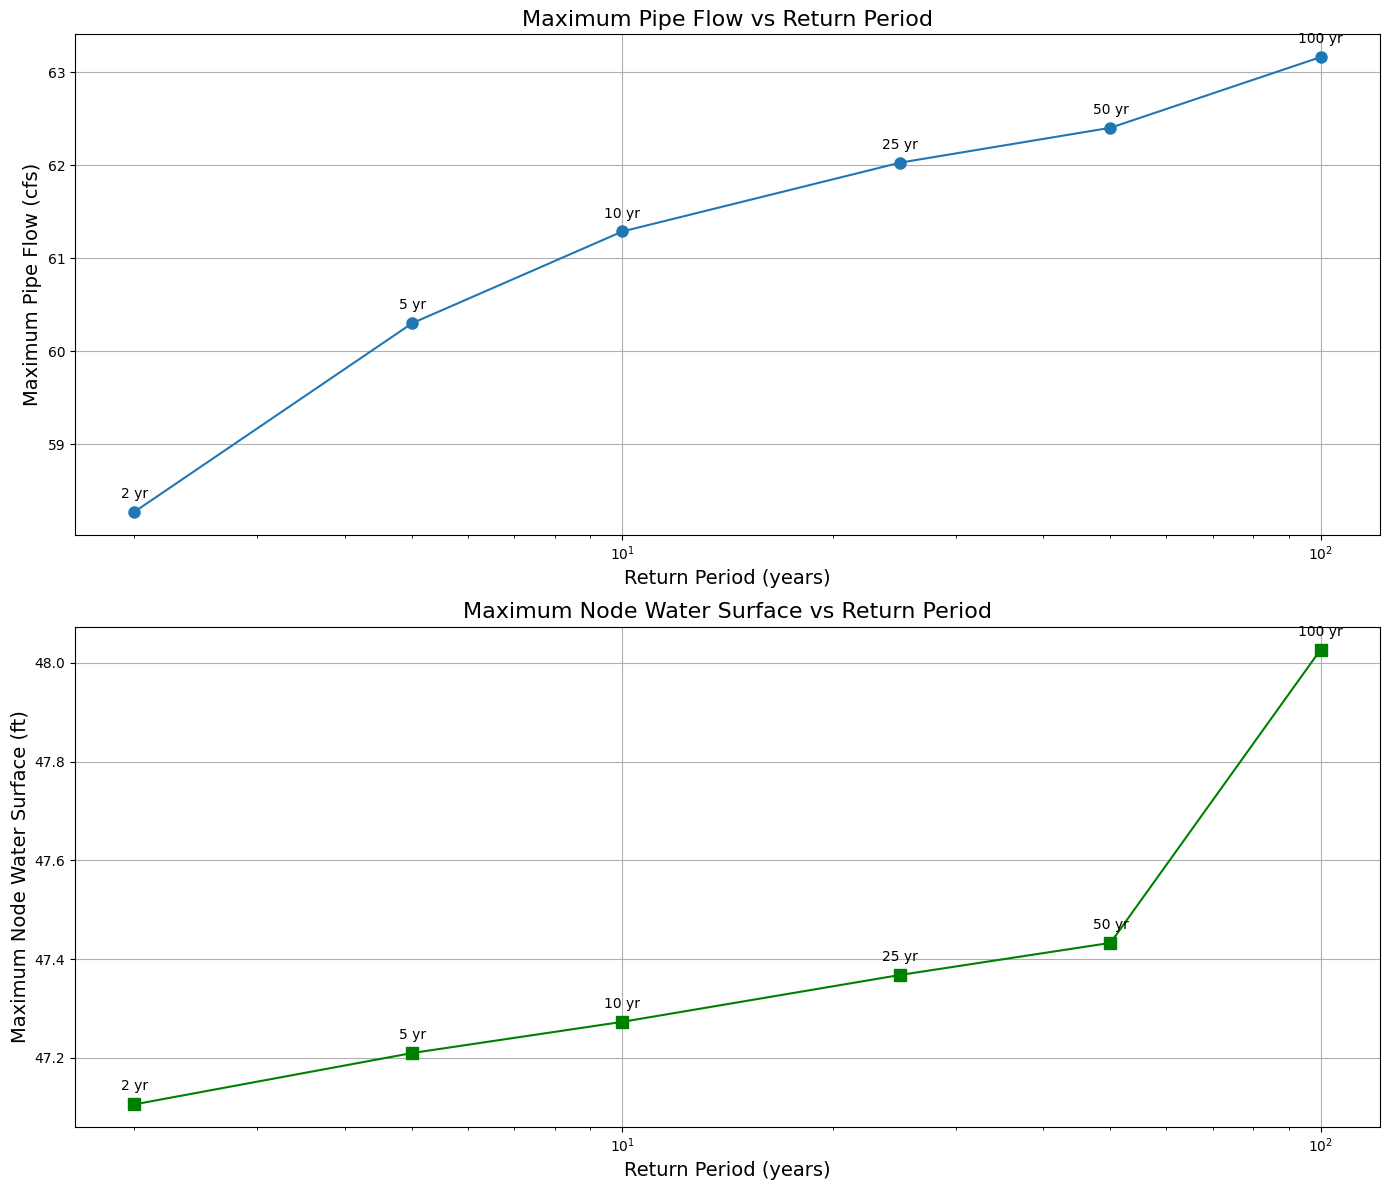

2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - INFO - Using HDF file from direct string path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p01.hdf
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:50 - ras_commander.hdf.HdfPipe - INFO - Using HDF file from di

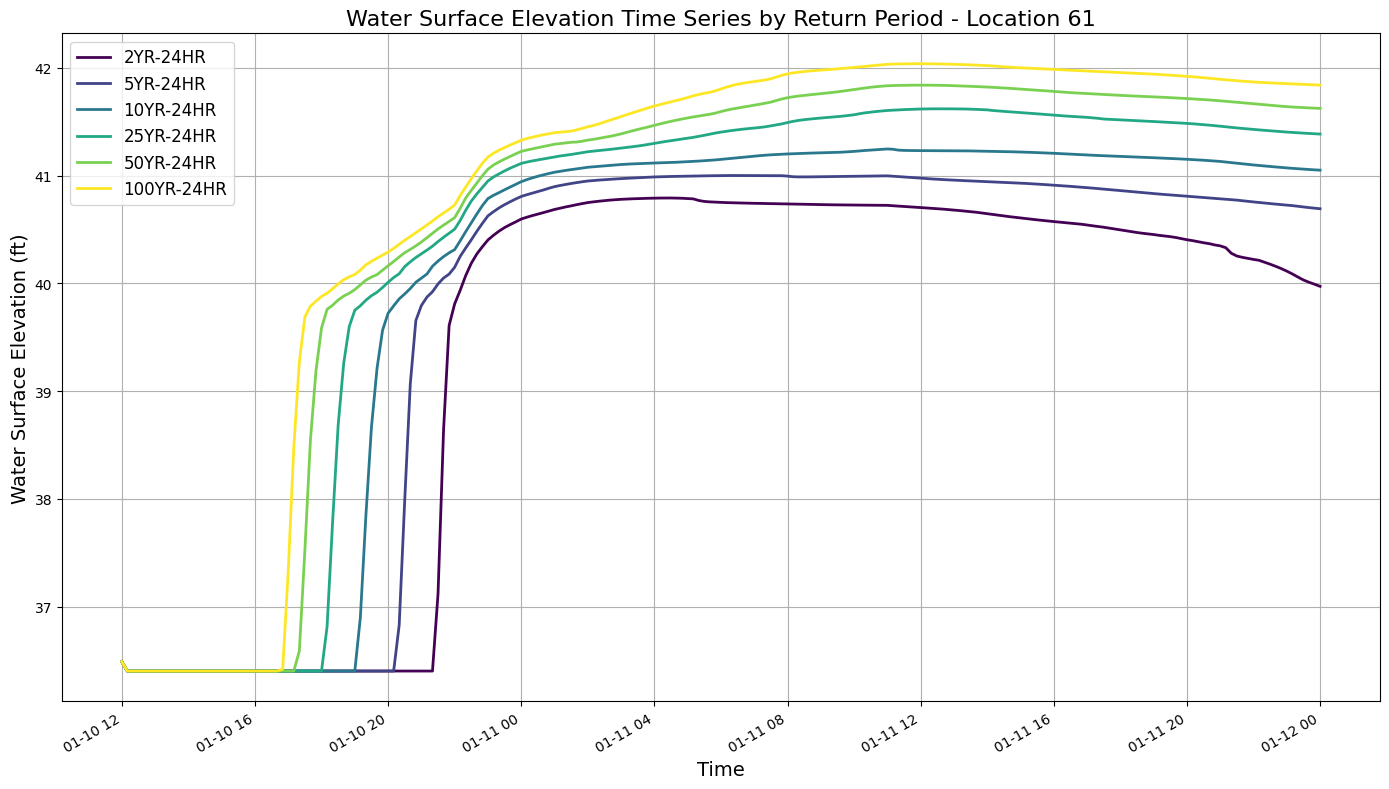

In [40]:
#---------------------------------------------------------------------
# Step 6: Plot the results
#---------------------------------------------------------------------
print("\nStep 6: Plotting the results...")

plot_results(analysis_df)

In [41]:
# Extract node water surface for a specific plan (e.g., 10-year AEP = plan 04)
# Use the compute_folder to find the correct HDF file
plan_04_hdf = compute_folder / "DavisStormSystem.p04.hdf"
if plan_04_hdf.exists():
    print(f"Reading node WS from: {plan_04_hdf}")
    node_ws = HdfPipe.get_pipe_network_timeseries(plan_04_hdf, variable="Nodes/Water Surface")
    print(f"Node WS data shape: {node_ws.shape if node_ws is not None else 'None'}")
else:
    print(f"HDF file not found: {plan_04_hdf}")
    node_ws = None

2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries


Reading node WS from: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
Node WS data shape: (217, 133)


In [42]:
node_ws

<xarray.DataArray 'Nodes/Water Surface' (time: 217, location: 133)> Size: 115kB
array([[26.98    , 25.79    , 28.87    , ..., 41.64    , 42.23    ,
        38.      ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       [26.93429 , 25.742727, 28.838373, ..., 40.804863, 41.99838 ,
        37.6068  ],
       ...,
       [40.33194 , 40.154865, 40.496986, ..., 40.816566, 42.010223,
        40.519657],
       [40.32187 , 40.145065, 40.486317, ..., 40.8163  , 42.010044,
        40.508324],
       [40.311813, 40.13525 , 40.47572 , ..., 40.816044, 42.00987 ,
        40.49715 ]], shape=(217, 133), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 126 127 128 129 130 131 132
Attributes:
    units:     ft
    variable:  Nodes/Water Surface

In [43]:
# Extract pipe flow for a specific plan (e.g., 10-year AEP = plan 04)
# Use the compute_folder to find the correct HDF file
plan_04_hdf = compute_folder / "DavisStormSystem.p04.hdf"
if plan_04_hdf.exists():
    print(f"Reading pipe flow from: {plan_04_hdf}")
    pipe_flow_ds = HdfPipe.get_pipe_network_timeseries(plan_04_hdf, variable="Pipes/Pipe Flow DS")
    print(f"Pipe flow data shape: {pipe_flow_ds.shape if pipe_flow_ds is not None else 'None'}")
else:
    print(f"HDF file not found: {plan_04_hdf}")
    pipe_flow_ds = None

2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - DEBUG - Calling get_pipe_network_timeseries
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - DEBUG - Successfully opened HDF file for validation: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
2025-12-29 07:18:51 - ras_commander.hdf.HdfPipe - DEBUG - Finished get_pipe_network_timeseries


Reading pipe flow from: C:\GH\ras-commander\examples\example_projects\Davis_30_build_aep_storms\compute_aep_parallel\DavisStormSystem.p04.hdf
Pipe flow data shape: (217, 132)


In [44]:
pipe_flow_ds

<xarray.DataArray 'Pipes/Pipe Flow DS' (time: 217, location: 132)> Size: 115kB
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, ...,
        -0.0000000e+00, -0.0000000e+00, -0.0000000e+00],
       ...,
       [ 5.1740509e+01,  2.2795265e+01,  5.1741089e+01, ...,
         1.0633519e-03,  5.7101989e-04,  1.2437071e-03],
       [ 5.1701267e+01,  2.2716499e+01,  5.1701866e+01, ...,
         1.0785813e-03,  5.5132189e-04,  1.2681994e-03],
       [ 5.1665817e+01,  2.2648956e+01,  5.1666412e+01, ...,
         1.0612747e-03,  5.3235039e-04,  1.2497426e-03]],
      shape=(217, 132), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * location  (location) int64 1kB 0 1 2 3 4 5 6 ... 125 126 127 128 129 130 131
Attributes:
    units:     ft^3/s
    variable:  Pipes/Pipe Flow DS

## Conclusion

This notebook demonstrates a comprehensive workflow for automated AEP storm analysis using RAS-Commander. The key benefits of this approach include:

1. **Efficiency**: Automating repetitive tasks saves time and reduces errors
2. **Consistency**: Ensures consistent methodology across all return periods
3. **Parallel Execution**: Makes optimal use of computational resources
4. **Comprehensive Analysis**: Extracts and visualizes key metrics across return periods
5. **Reproducibility**: The entire workflow is documented and repeatable

This approach can be extended to include additional analyses, such as:

- Comparing different storm patterns (e.g., position of peak intensity)
- Analyzing climate change scenarios by adjusting precipitation depths
- Evaluating infrastructure improvements by comparing baseline and modified geometries
- Generating frequency curves for key hydraulic parameters

By leveraging the power of RAS-Commander, engineers can focus on interpreting results and making design decisions rather than managing model configurations.

# DEV NOTES: 

Need to add example of setting Start Time and End Time

Need to add function to library that will end-to-end model Atlas 14 AEP storms given an input lat/long, Return Interval and Duration, given a working geometry w/infiltration.  Running optional.

